# Instacart Market Basket Analysis


https://www.kaggle.com/c/instacart-market-basket-analysis


## Description

Whether you shop from meticulously planned grocery lists or let whimsy guide your grazing, our unique food rituals define who we are. Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.

## Determine business objectives

### <span style="color:orange;">Which products will an Instacart consumer purchase again?

<span style="color:green;">Use the data on customer orders over time to predict which previously purchased products will be in a user’s next order.

## Dataset Description 


ref: https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b


The dataset is a relational set of files describing customers' orders over time. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, there is between 4 and 100 of their orders, with the sequence of products purchased in each order. It also contains the week and hour of day the order was placed, and a relative measure of time between orders.

### <span style="color:green;">deptartments (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

### <span style="color:green;">aisles (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

### <span style="color:green;">products (50k rows)
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

### <span style="color:green;">orders (3.4m rows, 206k users)
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

### <span style="color:green;">order_products__SET (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)


## Result

For each order_id in the test set, you should predict a space-delimited list of product_ids for that order. If you wish to predict an empty order, you should submit an explicit `None` value. You may combine `None` with product_ids. The spelling of `None` is case sensitive in the scoring metric. The file should have a header and look like the following:

```
order_id,products  
17,1 2  
34,None  
137,1 2 3  
etc.
```



In [2]:
import time
from collections import OrderedDict
import time
from sys import getsizeof
import gc
import math
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import squarify

from sklearn.compose import make_column_selector, ColumnTransformer, make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, roc_curve, make_scorer, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# Suppress all warnings globally
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 75)

notebook_start_time = time.time()

In [3]:
%config Completer.use_jedi = False

# Data Understanding

## Collecting Initial Data

In [6]:
%%time
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')

CPU times: user 6.88 s, sys: 1.57 s, total: 8.45 s
Wall time: 8.62 s


## Describe Data

### Departments

In [9]:
departments.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [10]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


In [11]:
departments.isnull().sum()

department_id    0
department       0
dtype: int64

In [12]:
departments.duplicated().sum()

0

In [13]:
departments.nunique()

department_id    21
department       21
dtype: int64

In [14]:
departments.describe()

department_id
count      21.000000
mean       11.000000
std         6.204837
min         1.000000
25%         6.000000
50%        11.000000
75%        16.000000
max        21.000000

In [15]:
departments.describe(include=[object])

department
count          21
unique         21
top        frozen
freq            1

### Aisles

In [17]:
aisles.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [18]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [19]:
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [20]:
aisles.duplicated().sum()

0

In [21]:
aisles.nunique()

aisle_id    134
aisle       134
dtype: int64

In [22]:
aisles.describe()

aisle_id
count  134.000000
mean    67.500000
std     38.826537
min      1.000000
25%     34.250000
50%     67.500000
75%    100.750000
max    134.000000

In [23]:
aisles.describe(include=[object])

aisle
count                     134
unique                    134
top     prepared soups salads
freq                        1

### Products

In [25]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [26]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [27]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [28]:
products.duplicated().sum()

0

In [29]:
products.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64

In [30]:
products.describe()

product_id      aisle_id  department_id
count  49688.000000  49688.000000   49688.000000
mean   24844.500000     67.769582      11.728687
std    14343.834425     38.316162       5.850410
min        1.000000      1.000000       1.000000
25%    12422.750000     35.000000       7.000000
50%    24844.500000     69.000000      13.000000
75%    37266.250000    100.000000      17.000000
max    49688.000000    134.000000      21.000000

In [31]:
products.describe(include=[object])

product_name
count                        49688
unique                       49688
top     Chocolate Sandwich Cookies
freq                             1

### Orders

In [33]:
orders.head(100)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329        1    prior             1          2                  8   
1    2398795        1    prior             2          3                  7   
2     473747        1    prior             3          3                 12   
3    2254736        1    prior             4          4                  7   
4     431534        1    prior             5          4                 15   
..       ...      ...      ...           ...        ...                ...   
95   1468214       11    prior             7          5                  9   
96   1376945       11     test             8          6                 11   
97   1483446       12    prior             1          1                 12   
98   1247527       12    prior             2          5                  9   
99   1916106       12    prior             3          5                  8   

    days_since_prior_order  
0                      NaN  
1                     15.0  
2                     21.0  
3                     29.0  
4                     28.0  
..                     ...  
95                    30.0  
96                     8.0  
97                     NaN  
98                    30.0  
99                    14.0  

[100 rows x 7 columns]

In [34]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [35]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [36]:
# days_since_prior_order is expected to have null when order_number is 1. Lets do this again ignoring order_number = 1
orders.loc[orders['order_number'] != 1].isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [37]:
orders.duplicated().sum()

0

In [38]:
orders.nunique()

order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64

In [39]:
orders.describe()

order_id       user_id  order_number     order_dow  \
count  3.421083e+06  3.421083e+06  3.421083e+06  3.421083e+06   
mean   1.710542e+06  1.029782e+05  1.715486e+01  2.776219e+00   
std    9.875817e+05  5.953372e+04  1.773316e+01  2.046829e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    8.552715e+05  5.139400e+04  5.000000e+00  1.000000e+00   
50%    1.710542e+06  1.026890e+05  1.100000e+01  3.000000e+00   
75%    2.565812e+06  1.543850e+05  2.300000e+01  5.000000e+00   
max    3.421083e+06  2.062090e+05  1.000000e+02  6.000000e+00   

       order_hour_of_day  days_since_prior_order  
count       3.421083e+06            3.214874e+06  
mean        1.345202e+01            1.111484e+01  
std         4.226088e+00            9.206737e+00  
min         0.000000e+00            0.000000e+00  
25%         1.000000e+01            4.000000e+00  
50%         1.300000e+01            7.000000e+00  
75%         1.600000e+01            1.500000e+01  
max         2.300000e+01            3.000000e+01

In [40]:
orders.describe(include=[object])

eval_set
count   3421083
unique        3
top       prior
freq    3214874

### Orders Products prior to that users most recent order

In [42]:
order_products_prior.head(20)

order_id  product_id  add_to_cart_order  reordered
0          2       33120                  1          1
1          2       28985                  2          1
2          2        9327                  3          0
3          2       45918                  4          1
4          2       30035                  5          0
5          2       17794                  6          1
6          2       40141                  7          1
7          2        1819                  8          1
8          2       43668                  9          0
9          3       33754                  1          1
10         3       24838                  2          1
11         3       17704                  3          1
12         3       21903                  4          1
13         3       17668                  5          1
14         3       46667                  6          1
15         3       17461                  7          1
16         3       32665                  8          1
17         4       46842                  1          0
18         4       26434                  2          1
19         4       39758                  3          1

In [43]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [44]:
order_products_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [45]:
%%time
order_products_prior.duplicated().sum()

CPU times: user 6.53 s, sys: 1.12 s, total: 7.65 s
Wall time: 7.67 s


0

In [46]:
order_products_prior.nunique()

order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64

In [47]:
order_products_prior.describe()

order_id    product_id  add_to_cart_order     reordered
count  3.243449e+07  3.243449e+07       3.243449e+07  3.243449e+07
mean   1.710749e+06  2.557634e+04       8.351076e+00  5.896975e-01
std    9.873007e+05  1.409669e+04       7.126671e+00  4.918886e-01
min    2.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00
25%    8.559430e+05  1.353000e+04       3.000000e+00  0.000000e+00
50%    1.711048e+06  2.525600e+04       6.000000e+00  1.000000e+00
75%    2.565514e+06  3.793500e+04       1.100000e+01  1.000000e+00
max    3.421083e+06  4.968800e+04       1.450000e+02  1.000000e+00

### Orders Products training data

In [49]:
order_products_train.head(20)

order_id  product_id  add_to_cart_order  reordered
0          1       49302                  1          1
1          1       11109                  2          1
2          1       10246                  3          0
3          1       49683                  4          0
4          1       43633                  5          1
5          1       13176                  6          0
6          1       47209                  7          0
7          1       22035                  8          1
8         36       39612                  1          0
9         36       19660                  2          1
10        36       49235                  3          0
11        36       43086                  4          1
12        36       46620                  5          1
13        36       34497                  6          1
14        36       48679                  7          1
15        36       46979                  8          1
16        38       11913                  1          0
17        38       18159                  2          0
18        38        4461                  3          0
19        38       21616                  4          1

In [50]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [51]:
order_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [52]:
order_products_train.duplicated().sum()

0

In [53]:
order_products_train.nunique()

order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64

In [54]:
order_products_train.describe()

order_id    product_id  add_to_cart_order     reordered
count  1.384617e+06  1.384617e+06       1.384617e+06  1.384617e+06
mean   1.706298e+06  2.555624e+04       8.758044e+00  5.985944e-01
std    9.897326e+05  1.412127e+04       7.423936e+00  4.901829e-01
min    1.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00
25%    8.433700e+05  1.338000e+04       3.000000e+00  0.000000e+00
50%    1.701880e+06  2.529800e+04       7.000000e+00  1.000000e+00
75%    2.568023e+06  3.794000e+04       1.200000e+01  1.000000e+00
max    3.421070e+06  4.968800e+04       8.000000e+01  1.000000e+00

## Pre EDA

### combining order_products_prior and order_products_train as order_products

In [57]:
# combining train and prior order_products
order_products = pd.concat(objs=[order_products_train, order_products_prior])

In [58]:
order_products.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [59]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33819106 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 1.3 GB


In [60]:
order_products.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [61]:
%%time
order_products.duplicated().sum()

CPU times: user 7.06 s, sys: 1.8 s, total: 8.86 s
Wall time: 8.93 s


0

In [62]:
order_products.nunique()

order_id             3346083
product_id             49685
add_to_cart_order        145
reordered                  2
dtype: int64

In [63]:
order_products.describe()

order_id    product_id  add_to_cart_order     reordered
count  3.381911e+07  3.381911e+07       3.381911e+07  3.381911e+07
mean   1.710566e+06  2.557551e+04       8.367738e+00  5.900617e-01
std    9.874008e+05  1.409770e+04       7.139540e+00  4.918220e-01
min    1.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00
25%    8.554130e+05  1.351900e+04       3.000000e+00  0.000000e+00
50%    1.710660e+06  2.525600e+04       6.000000e+00  1.000000e+00
75%    2.565587e+06  3.793500e+04       1.100000e+01  1.000000e+00
max    3.421083e+06  4.968800e+04       1.450000e+02  1.000000e+00

### order_products_extended by merging order_products with products, aisles and departments

In [65]:
%%time
order_products_extended = pd.merge(left=order_products, right=products, on='product_id', how='left')
order_products_extended = pd.merge(left=order_products_extended, right=aisles, on='aisle_id', how='left')
order_products_extended = pd.merge(left=order_products_extended, right=departments, on='department_id', how='left')

CPU times: user 10.8 s, sys: 4.24 s, total: 15 s
Wall time: 15.6 s


In [66]:
order_products_extended.head()

order_id  product_id  add_to_cart_order  reordered  \
0         1       49302                  1          1   
1         1       11109                  2          1   
2         1       10246                  3          0   
3         1       49683                  4          0   
4         1       43633                  5          1   

                                    product_name  aisle_id  department_id  \
0                               Bulgarian Yogurt       120             16   
1  Organic 4% Milk Fat Whole Milk Cottage Cheese       108             16   
2                          Organic Celery Hearts        83              4   
3                                 Cucumber Kirby        83              4   
4           Lightly Smoked Sardines in Olive Oil        95             15   

                  aisle    department  
0                yogurt    dairy eggs  
1  other creams cheeses    dairy eggs  
2      fresh vegetables       produce  
3      fresh vegetables       produce  
4   canned meat seafood  canned goods

In [67]:
order_products_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           int64 
 1   product_id         int64 
 2   add_to_cart_order  int64 
 3   reordered          int64 
 4   product_name       object
 5   aisle_id           int64 
 6   department_id      int64 
 7   aisle              object
 8   department         object
dtypes: int64(6), object(3)
memory usage: 2.3+ GB


In [68]:
%%time
order_products_extended.isnull().sum()

CPU times: user 3.15 s, sys: 75.3 ms, total: 3.23 s
Wall time: 3.23 s


order_id             0
product_id           0
add_to_cart_order    0
reordered            0
product_name         0
aisle_id             0
department_id        0
aisle                0
department           0
dtype: int64

In [69]:
%%time
order_products_extended.duplicated().sum()

CPU times: user 20.9 s, sys: 3.29 s, total: 24.2 s
Wall time: 24.3 s


0

In [70]:
%%time
order_products_extended.nunique()

CPU times: user 7.12 s, sys: 259 ms, total: 7.38 s
Wall time: 7.44 s


order_id             3346083
product_id             49685
add_to_cart_order        145
reordered                  2
product_name           49685
aisle_id                 134
department_id             21
aisle                    134
department                21
dtype: int64

In [71]:
%%time
order_products_extended.describe()

CPU times: user 5.38 s, sys: 1.04 s, total: 6.42 s
Wall time: 6.57 s


order_id    product_id  add_to_cart_order     reordered  \
count  3.381911e+07  3.381911e+07       3.381911e+07  3.381911e+07   
mean   1.710566e+06  2.557551e+04       8.367738e+00  5.900617e-01   
std    9.874008e+05  1.409770e+04       7.139540e+00  4.918220e-01   
min    1.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00   
25%    8.554130e+05  1.351900e+04       3.000000e+00  0.000000e+00   
50%    1.710660e+06  2.525600e+04       6.000000e+00  1.000000e+00   
75%    2.565587e+06  3.793500e+04       1.100000e+01  1.000000e+00   
max    3.421083e+06  4.968800e+04       1.450000e+02  1.000000e+00   

           aisle_id  department_id  
count  3.381911e+07   3.381911e+07  
mean   7.121799e+01   9.918544e+00  
std    3.819898e+01   6.281655e+00  
min    1.000000e+00   1.000000e+00  
25%    3.100000e+01   4.000000e+00  
50%    8.300000e+01   9.000000e+00  
75%    1.070000e+02   1.600000e+01  
max    1.340000e+02   2.100000e+01

In [72]:
%%time
order_products_extended.describe(include=[object])

CPU times: user 9.78 s, sys: 879 ms, total: 10.7 s
Wall time: 10.7 s


product_name         aisle department
count      33819106      33819106   33819106
unique        49685           134         21
top          Banana  fresh fruits    produce
freq         491291       3792661    9888378

### Merging products, aisles and departments as inventory

In [74]:
inventory = pd.merge(left=products, right=aisles, on='aisle_id', how='left')
inventory = pd.merge(left=inventory, right=departments, on='department_id', how='left')

In [75]:
inventory.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle department  
0             19               cookies cakes     snacks  
1             13           spices seasonings     pantry  
2              7                         tea  beverages  
3              1                frozen meals     frozen  
4             13  marinades meat preparation     pantry

In [76]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
 4   aisle          49688 non-null  object
 5   department     49688 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.3+ MB


In [77]:
inventory.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
aisle            0
department       0
dtype: int64

In [78]:
inventory.duplicated().sum()

0

In [79]:
inventory.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
aisle              134
department          21
dtype: int64

In [80]:
inventory.nunique()

product_id       49688
product_name     49688
aisle_id           134
department_id       21
aisle              134
department          21
dtype: int64

In [81]:
inventory.describe()

product_id      aisle_id  department_id
count  49688.000000  49688.000000   49688.000000
mean   24844.500000     67.769582      11.728687
std    14343.834425     38.316162       5.850410
min        1.000000      1.000000       1.000000
25%    12422.750000     35.000000       7.000000
50%    24844.500000     69.000000      13.000000
75%    37266.250000    100.000000      17.000000
max    49688.000000    134.000000      21.000000

In [82]:
inventory.describe(include=[object])

product_name    aisle     department
count                        49688    49688          49688
unique                       49688      134             21
top     Chocolate Sandwich Cookies  missing  personal care
freq                             1     1258           6563

## EDA - Exploratory Data Analysis

* How many orders each user made using histogram.
* Which products are ordered the most
* Which products are reordered the most
* How often products are reordered using histogram.
* Aisle with more products.
* Departments with more products.
* During what time of the day were most ordered placed.
* Products share by Department and Aisle using Treemap.
* Distribution of 'reordered' products
* % Orders which contain reordered products and no reordered products



When a user orders a product, what is the change of it being reordered?

### How many orders each user made

In [85]:
orders.head(2)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   

   days_since_prior_order  
0                     NaN  
1                    15.0

In [86]:
%%time
orders_by_user = orders.groupby(['user_id'])['order_number'].max().reset_index()

CPU times: user 80.5 ms, sys: 20.9 ms, total: 101 ms
Wall time: 100 ms


In [87]:
orders_by_user.head()

user_id  order_number
0        1            11
1        2            15
2        3            13
3        4             6
4        5             5

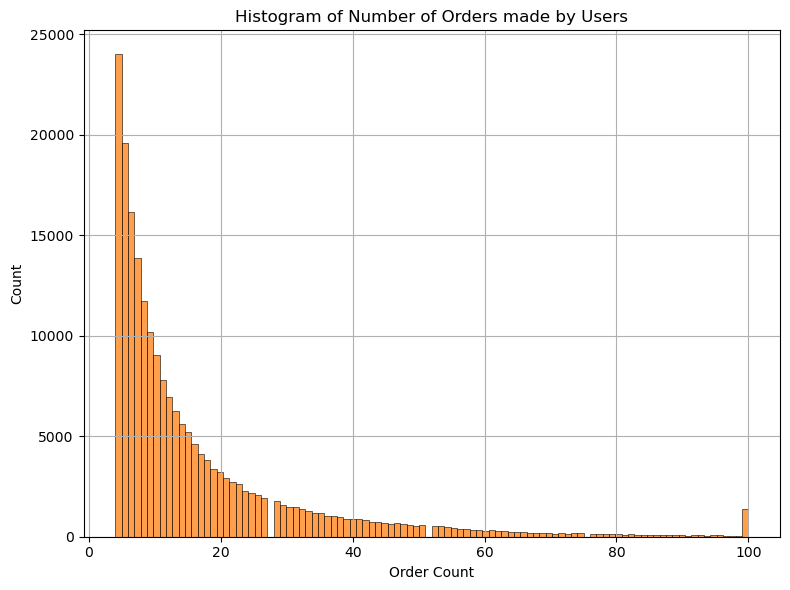

In [88]:
plt.figure(figsize=(8,6))
sns.histplot(data=orders_by_user['order_number'], color='tab:orange', bins=100)
plt.xlabel('Order Count')
plt.ylabel('Count')
plt.title('Histogram of Number of Orders made by Users')
plt.grid()
plt.tight_layout()
plt.savefig('images/orders_by_users_histo.png')
plt.show()

### Which products are ordered the most

In [90]:
%%time
product_name_df = order_products_extended['product_name'].value_counts().reset_index()

CPU times: user 2.45 s, sys: 24.5 ms, total: 2.48 s
Wall time: 2.47 s


In [91]:
product_name_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49685 entries, 0 to 49684
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  49685 non-null  object
 1   count         49685 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 776.5+ KB


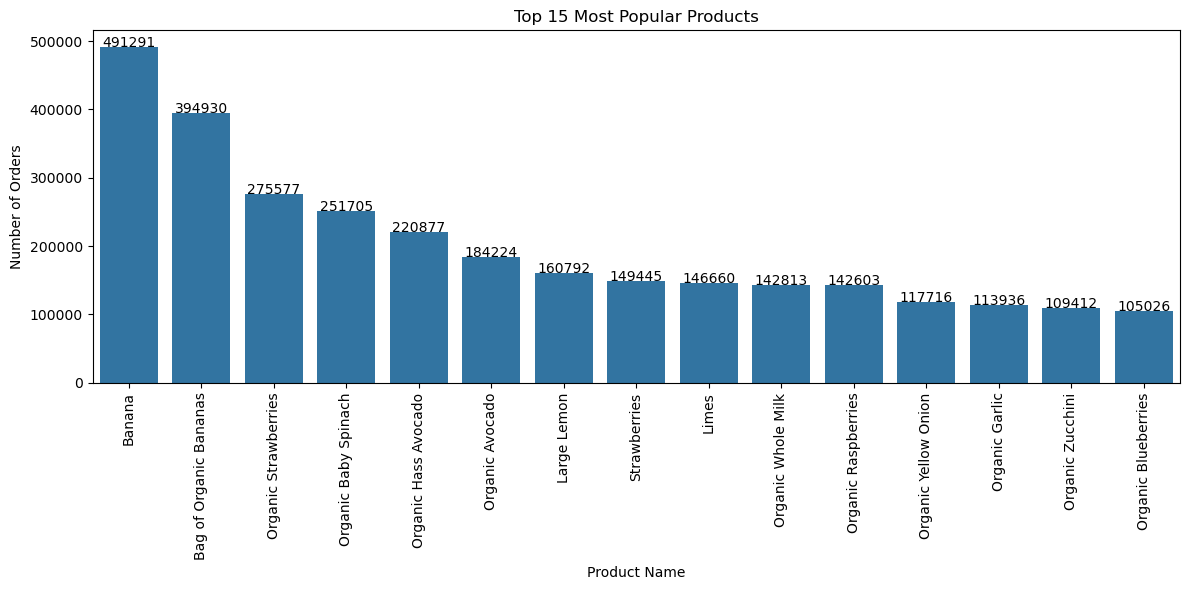

In [92]:
top_n = 15
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=product_name_df.head(top_n), x='product_name', y='count')
for index, count in enumerate(product_name_df.head(top_n)['count']):
    bar_plot.text(index, count, s=f'{count}', color='black', ha="center")
# plt.tight_layout()
plt.title(f'Top {top_n} Most Popular Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/top_most_popular_products.png')
plt.show()


### Which products are reordered the most

In [94]:
products_reordered_df = order_products_extended.loc[order_products_extended['reordered'] == 1]['product_name'].\
    value_counts().reset_index()

In [95]:
products_reordered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45603 entries, 0 to 45602
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  45603 non-null  object
 1   count         45603 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 712.7+ KB


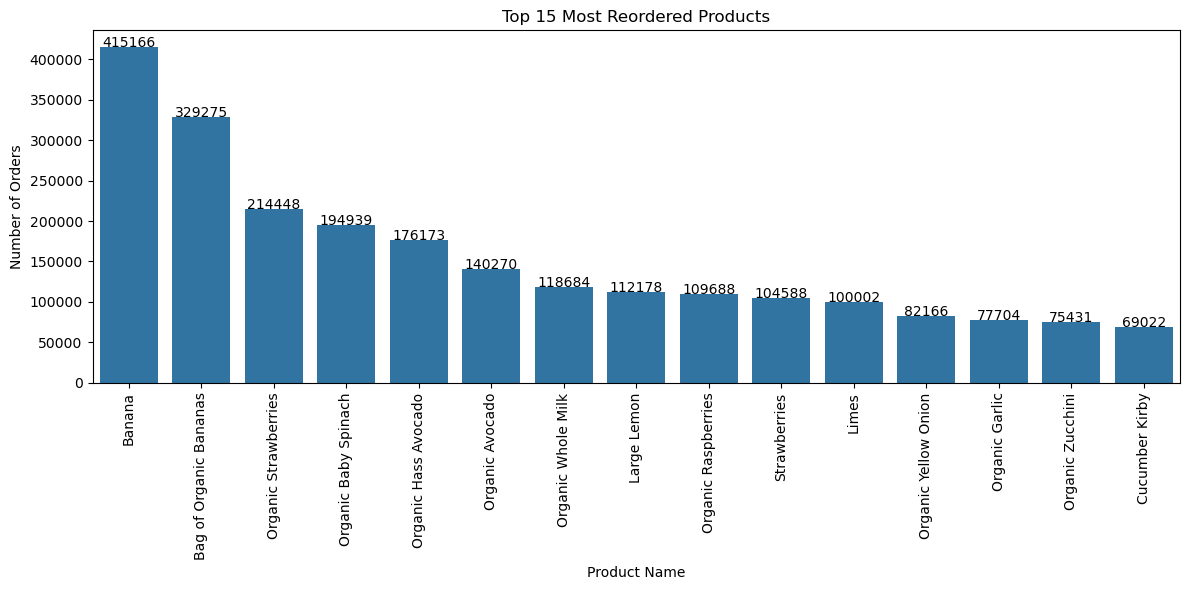

In [96]:
top_n = 15
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(data=products_reordered_df.head(top_n), x='product_name', y='count')
for index, count in enumerate(products_reordered_df.head(top_n)['count']):
    bar_plot.text(index, count, s=f'{count}', color='black', ha="center")
# plt.tight_layout()
plt.title(f'Top {top_n} Most Reordered Products')
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/top_most_reordered_products.png')
plt.show()

### How often products are reordered using histogram

In [98]:
%%time
products_reordered = order_products_extended['product_name'].value_counts().reset_index()

CPU times: user 2.48 s, sys: 26 ms, total: 2.5 s
Wall time: 2.49 s


In [99]:
products_reordered.head()

product_name   count
0                  Banana  491291
1  Bag of Organic Bananas  394930
2    Organic Strawberries  275577
3    Organic Baby Spinach  251705
4    Organic Hass Avocado  220877

In [100]:
products_reordered['count'] = products_reordered['count'].apply(lambda x: min(x, 500))

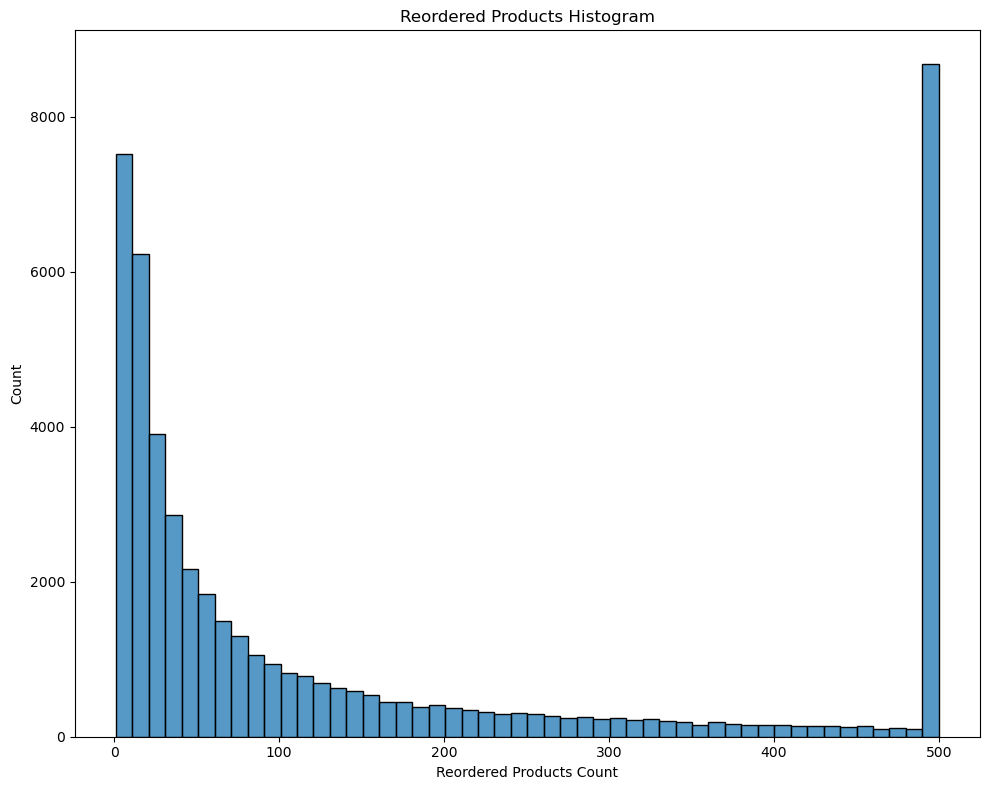

CPU times: user 476 ms, sys: 86.3 ms, total: 562 ms
Wall time: 306 ms


In [101]:
%%time
plt.figure(figsize=(10, 8))
sns.histplot(data=products_reordered['count'], bins=50)
plt.title(f'Reordered Products Histogram')
plt.xlabel('Reordered Products Count')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('images/reordered_products_histo.png')
plt.show()

### Which Aisles and Departments have more products

In [103]:
inventory.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id                       aisle department  
0             19               cookies cakes     snacks  
1             13           spices seasonings     pantry  
2              7                         tea  beverages  
3              1                frozen meals     frozen  
4             13  marinades meat preparation     pantry

In [104]:
top_aisles = inventory.groupby('aisle').count()['product_id'].sort_values(ascending=False).reset_index()

In [105]:
top_aisles.head()

aisle  product_id
0               missing        1258
1       candy chocolate        1246
2         ice cream ice        1091
3  vitamins supplements        1038
4                yogurt        1026

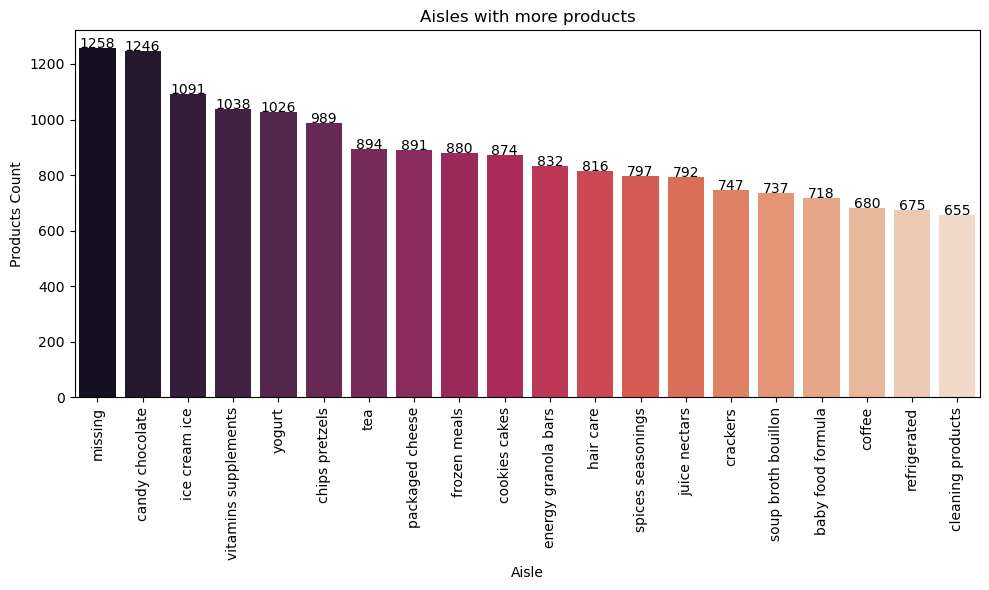

In [106]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=top_aisles.head(20), x='aisle', y='product_id', palette='rocket', hue='aisle')
for index, value in enumerate(top_aisles.head(20)['product_id']):
    bar_plot.text(x=index, y=value, s=f'{value}', ha='center')
plt.title('Aisles with more products')
plt.xlabel('Aisle')
plt.ylabel('Products Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/aisles_with_products.png')
plt.show()

In [107]:
top_departments = inventory.groupby('department').count()['product_id'].sort_values(ascending=False).reset_index()

In [108]:
top_departments.head()

department  product_id
0  personal care        6563
1         snacks        6264
2         pantry        5371
3      beverages        4365
4         frozen        4007

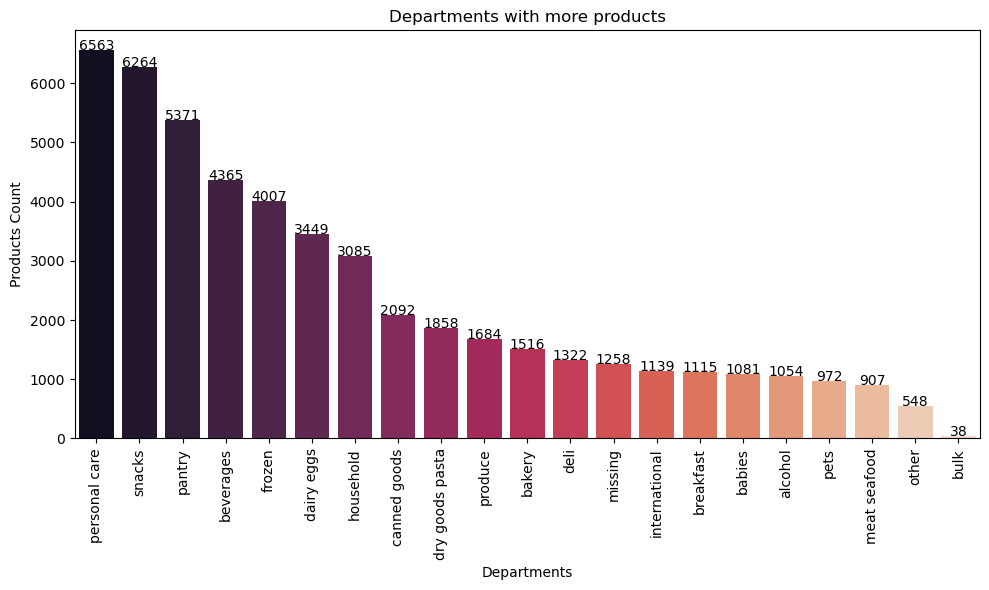

In [109]:
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=top_departments, x='department', y='product_id', palette='rocket', hue='department')
for index, value in enumerate(top_departments['product_id']):
    bar_plot.text(x=index, y=value, s=f'{value}', ha='center')
plt.title('Departments with more products')
plt.xlabel('Departments')
plt.ylabel('Products Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('images/departments_with_products.png')
plt.show()

### During what time of the day were most ordered placed

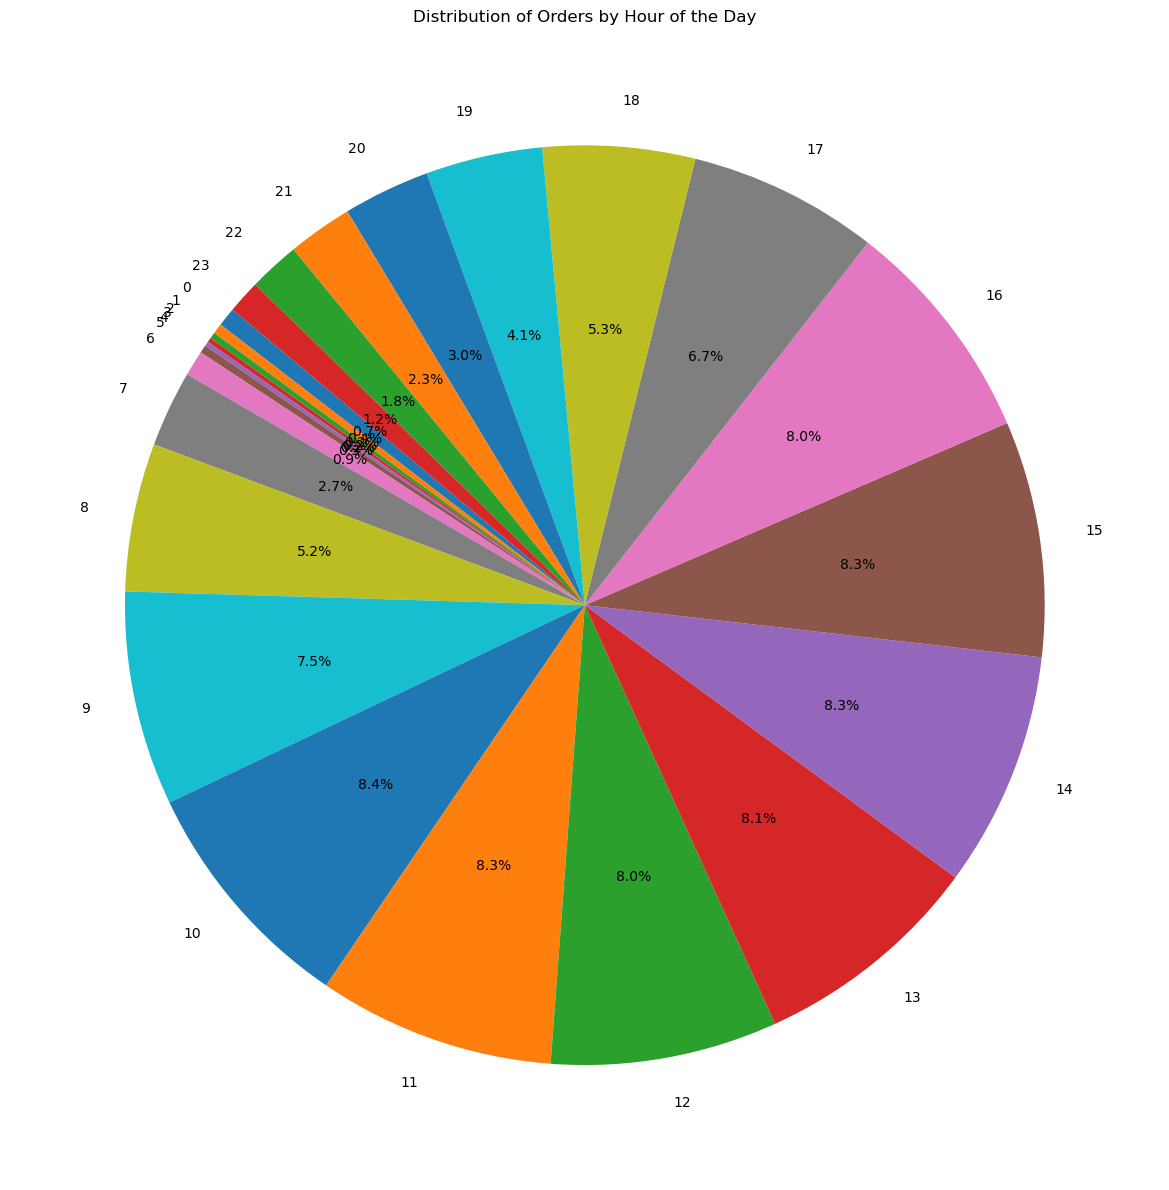

In [111]:
counts = orders['order_hour_of_day'].value_counts()

# Sort the counts by the hour of the day (the index)
counts = counts.sort_index()

# Create the pie chart
plt.figure(figsize=(12, 12))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Orders by Hour of the Day')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.savefig('images/orders_by_hr.png')

# Show the plot
plt.show()


### Product Treemap by Department and Aisle

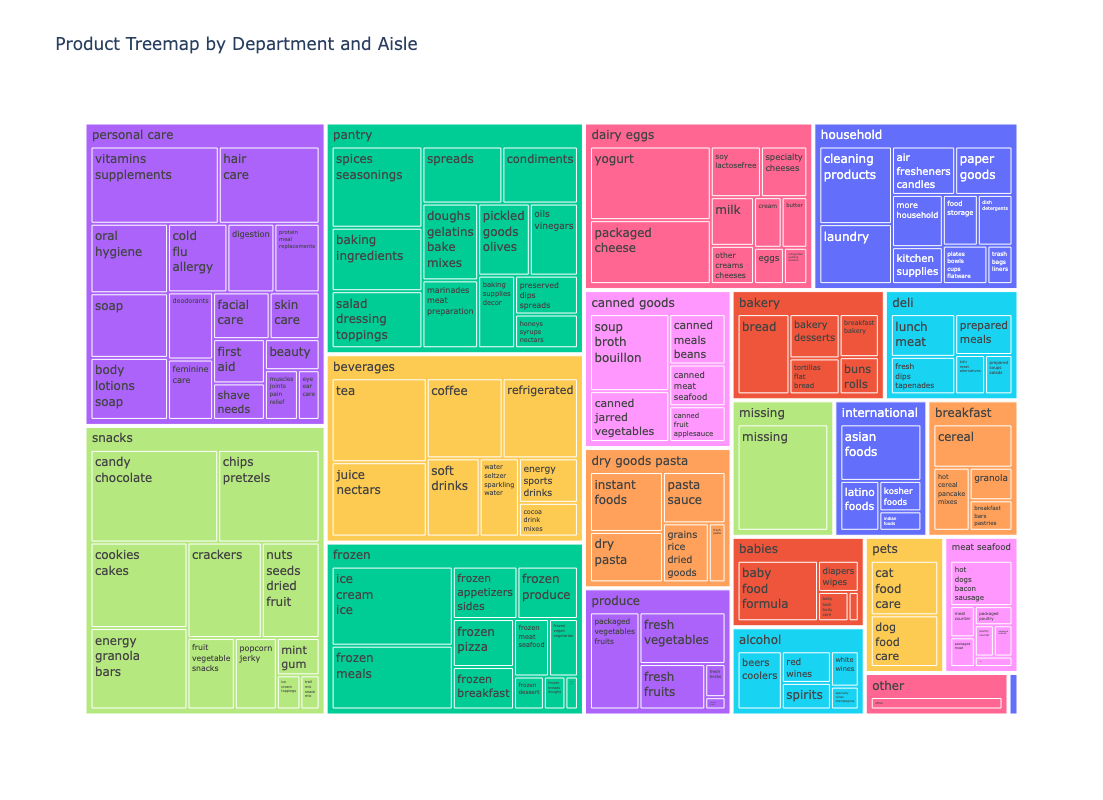

CPU times: user 685 ms, sys: 456 ms, total: 1.14 s
Wall time: 3.17 s


In [113]:
%%time

import plotly.express as px
import textwrap

# Aggregate data by department and aisle
aggregated_data = inventory.groupby(['department', 'aisle']).size().reset_index(name='count')

# Function to wrap text for labels
def wrap_text(text, width=5):
    words = text.split(' ')
    lines = []
    current_line = []
    current_length = 0
    for word in words:
        if current_length + len(word) + 1 <= width:
            current_line.append(word)
            current_length += len(word) + 1
        else:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word) + 1
    lines.append(' '.join(current_line))
    return '<br>'.join(lines)

# Apply word wrapping to labels
# textwrap is not helpful when you want text wrap on space first and then on width. So, it could wrap word in more than 1 line
# aggregated_data['wrapped_aisle'] = aggregated_data['aisle'].apply(lambda x: "<br>".join(textwrap.wrap(x,width=12)))
aggregated_data['wrapped_aisle'] = aggregated_data['aisle'].apply(lambda x: wrap_text(x))

# Create the treemap with different colors for each department
fig = px.treemap(
    aggregated_data, 
    path=['department', 'wrapped_aisle'], 
    values='count',
    color='department',  # Set color dimension to department
    title='Product Treemap by Department and Aisle',
    width=1100,
    height=800
)

fig.write_image('images/product_treemap.png')
# Show the plot
fig.show()


### Distribution of 'reordered' products

In [115]:
order_products.head(10)

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
5         1       13176                  6          0
6         1       47209                  7          0
7         1       22035                  8          1
8        36       39612                  1          0
9        36       19660                  2          1

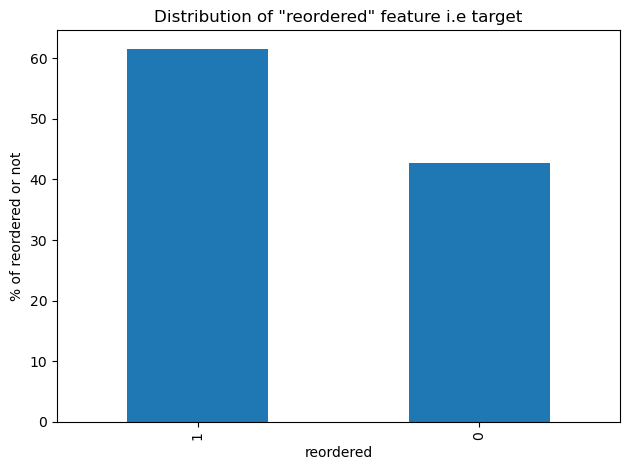

In [116]:
((order_products['reordered'].value_counts() / order_products_prior.shape[0]) * 100).plot.bar()
plt.ylabel('% of reordered or not')
plt.title('Distribution of "reordered" feature i.e target')
plt.tight_layout()
plt.savefig('images/reordered_distribution')
plt.show()

### % Orders which contain reordered products and no reordered products

In [118]:
reordered_counts = order_products.groupby(['order_id'])['reordered'].sum().reset_index(name='reordered_counts')
# print(reordered_counts.head())
orders_with_reordered_products = sum(reordered_counts['reordered_counts'] != 0)
orders_with_no_reordered_products = sum(reordered_counts['reordered_counts'] == 0)
# print(orders_with_reordered_products, orders_with_no_reordered_products)
reordered_pct = round((orders_with_reordered_products/(orders_with_reordered_products+orders_with_no_reordered_products))*100, 2)
no_reordered_pct = round((orders_with_no_reordered_products/(orders_with_reordered_products+orders_with_no_reordered_products))*100, 2)

print(f'% of Orders with reordered products: {reordered_pct}%')
print(f'% of Orders with no reordered products: {no_reordered_pct}%')


% of Orders with reordered products: 88.13%
% of Orders with no reordered products: 11.87%


# Data Preparation

## Select Data

### Create Training data by using order_products_prior and order_products_train)
* Create additional features using order_products_prior.
* 1. Get train eval set from orders.
2. Generate order_products_train_extended order_products_train similar to order_products_prior_extended.
3. last_orders: Get last orders for every user.
4. order_details: Get order_details with unique ['order_id','order_dow','order_hour_of_day','days_since_prior_order'] from order_products_train_extended
5. Generate order_products_train_final_df using new features, ['user_id','order_id','product_id','reordered'], last_orders and order_details.



In [121]:
%%time
print(f'size of order_products: {getsizeof(order_products)/(1024**3)} GB')
print(f'size of order_products_extended: {getsizeof(order_products_extended)/(1024**3)} GB')

size of order_products: 1.2598599046468735 GB
size of order_products_extended: 8.400338978506625 GB
CPU times: user 14.8 s, sys: 147 ms, total: 15 s
Wall time: 15.1 s


In [122]:
del order_products
del order_products_extended
gc.collect()

10551

In [123]:
orders.head(2)

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   

   days_since_prior_order  
0                     NaN  
1                    15.0

In [124]:
orders.shape

(3421083, 7)

In [125]:
order_products_prior.head(2)

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1

In [126]:
order_products_prior.shape

(32434489, 4)

In [127]:
order_products_train.head(2)

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1

In [128]:
order_products_train.shape

(1384617, 4)

In [129]:
%%time
# Merge 'order_products_prior' with 'orders' on 'order_id', excluding the 'eval_set' column from 'orders'.
# Dropping the eval_set column from orders ensures that only relevant data is merged as we don't have test data set here.
orders_with_products_prior = pd.merge(
    left=order_products_prior,
    right=orders.drop(columns=['eval_set']),
    how='inner',
    on='order_id'
)

CPU times: user 4.56 s, sys: 2.52 s, total: 7.09 s
Wall time: 7.44 s


In [130]:
orders_with_products_prior.head(3)

order_id  product_id  add_to_cart_order  reordered  user_id  order_number  \
0         2       33120                  1          1   202279             3   
1         2       28985                  2          1   202279             3   
2         2        9327                  3          0   202279             3   

   order_dow  order_hour_of_day  days_since_prior_order  
0          5                  9                     8.0  
1          5                  9                     8.0  
2          5                  9                     8.0

In [131]:
%%time
# Merge 'order_products_train' with 'orders' on 'order_id', excluding the 'eval_set' column from 'orders'.
# Dropping the eval_set column from orders ensures that only relevant data is merged.
orders_with_products_train = pd.merge(
    left=order_products_train,
    right=orders.drop(columns=['eval_set']),
    how='inner',
    on='order_id'
)

CPU times: user 567 ms, sys: 287 ms, total: 853 ms
Wall time: 857 ms


In [132]:
orders_with_products_train.head(3)

order_id  product_id  add_to_cart_order  reordered  user_id  order_number  \
0         1       49302                  1          1   112108             4   
1         1       11109                  2          1   112108             4   
2         1       10246                  3          0   112108             4   

   order_dow  order_hour_of_day  days_since_prior_order  
0          4                 10                     9.0  
1          4                 10                     9.0  
2          4                 10                     9.0

## Feature Engineering

### in_cart feature: Is product in latest cart/order

In [135]:
%%time
# Get number of times a product was ordered by a user from prior orders.

# Group by 'product_id' and 'user_id', counting the number of orders for each product by each user.
products_ordered_by_user_count = (orders_with_products_prior.groupby(['user_id', 'product_id'], as_index=False)
                                  .agg({'order_id': 'count'}).rename(columns={'order_id': 'ordered_count'}))


CPU times: user 9.56 s, sys: 1.52 s, total: 11.1 s
Wall time: 11.1 s


In [136]:
products_ordered_by_user_count.head()

user_id  product_id  ordered_count
0        1         196             10
1        1       10258              9
2        1       10326              1
3        1       12427             10
4        1       13032              3

In [137]:
%%time
# Extract unique 'user_id' values from orders we want to use for traning
user_ids_train = orders_with_products_train['user_id'].unique()

CPU times: user 20.4 ms, sys: 5.21 ms, total: 25.6 ms
Wall time: 24.1 ms


In [138]:
user_ids_train[0:4]

array([112108,  79431,  42756,  17227])

In [139]:
%%time
# Group 'orders_with_products_train' by 'user_id' and create a set of products in the user's latest cart.
train_carts = (orders_with_products_train.groupby('user_id', as_index=False)
                                      .agg({'product_id': (lambda x: set(x))})
                                      .rename(columns={'product_id': 'latest_cart'}))


CPU times: user 2.17 s, sys: 78.5 ms, total: 2.25 s
Wall time: 2.3 s


In [140]:
train_carts.head(2)

user_id                                        latest_cart
0        1  {196, 26405, 27845, 46149, 13032, 39657, 26088...
1        2  {24838, 11913, 45066, 31883, 48523, 38547, 248...

In [141]:
%%time
df_X = products_ordered_by_user_count[products_ordered_by_user_count['user_id'].isin(user_ids_train)]

CPU times: user 186 ms, sys: 13.4 ms, total: 199 ms
Wall time: 199 ms


In [142]:
df_X.head(3)

user_id  product_id  ordered_count
0        1         196             10
1        1       10258              9
2        1       10326              1

In [143]:
%%time
df_X = pd.merge(left=df_X, right=train_carts, how='inner', on='user_id')
df_X.head(3)

CPU times: user 311 ms, sys: 32.2 ms, total: 343 ms
Wall time: 343 ms


user_id  product_id  ordered_count  \
0        1         196             10   
1        1       10258              9   
2        1       10326              1   

                                         latest_cart  
0  {196, 26405, 27845, 46149, 13032, 39657, 26088...  
1  {196, 26405, 27845, 46149, 13032, 39657, 26088...  
2  {196, 26405, 27845, 46149, 13032, 39657, 26088...

In [144]:
%%time
df_X['in_cart'] = df_X.apply(lambda row: 1 if row['product_id'] in row['latest_cart'] else 0, axis=1)
df_X.head(3)

CPU times: user 49.6 s, sys: 912 ms, total: 50.5 s
Wall time: 50.9 s


user_id  product_id  ordered_count  \
0        1         196             10   
1        1       10258              9   
2        1       10326              1   

                                         latest_cart  in_cart  
0  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1  
1  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1  
2  {196, 26405, 27845, 46149, 13032, 39657, 26088...        0

In [145]:
# Calculate the percentage distribution of the 'in_cart' variable.
target_pcts = df_X['in_cart'].value_counts(normalize=True) * 100
target_pcts

in_cart
0    90.219975
1     9.780025
Name: proportion, dtype: float64

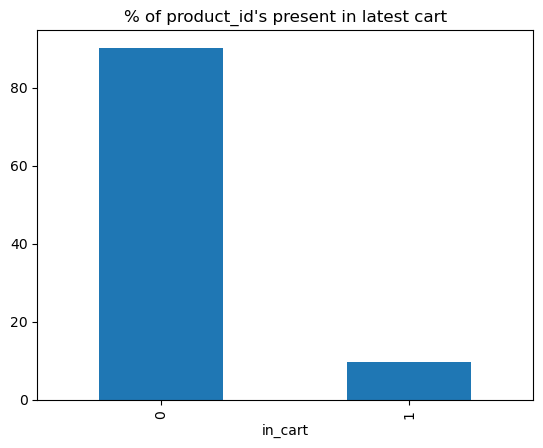

In [146]:
# Bar plot of the 'in_cart' variable.
target_pcts.plot(kind='bar')
plt.title('% of product_id\'s present in latest cart')
plt.savefig('images/%of_product_id_in_latest_cart.png')
plt.show()

CPU times: user 926 ms, sys: 181 ms, total: 1.11 s
Wall time: 576 ms


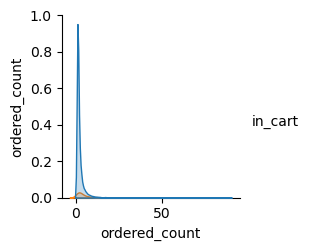

In [147]:
%%time
def plot_features(df, sample_size=500):
    # Take a random sample of 1000 rows, excluding identifier columns.
    sample = (df.drop(['product_id', 'user_id', 'latest_cart'], axis=1)
                .sample(10000, random_state=44))
    # Create pair plots colored by the 'in_cart' target variable.
    sns.pairplot(
        sample,
        hue='in_cart',
        plot_kws=dict(alpha=.3, edgecolor='none')
    )

# Plot features of 'df_X'
plot_features(df_X)


### Product features

* product_num_unique_orders: The number of unique orders in which each product appears.
* product_avg_add_to_cart_position: The average position at which each product is added to the cart.

In [149]:
orders_with_products_prior.head(3)

order_id  product_id  add_to_cart_order  reordered  user_id  order_number  \
0         2       33120                  1          1   202279             3   
1         2       28985                  2          1   202279             3   
2         2        9327                  3          0   202279             3   

   order_dow  order_hour_of_day  days_since_prior_order  
0          5                  9                     8.0  
1          5                  9                     8.0  
2          5                  9                     8.0

In [150]:
%%time

# Genrating features product_num_unique_orders and product_avg_add_to_cart_position.

# groups the orders_with_products_prior DataFrame by the product_id. aggregation functions
# applied to each group using OrderedDict to ensure that the aggregations are applied in a specific order.
df_prod_features = (orders_with_products_prior.groupby(['product_id'], as_index=False)
                                           .agg(OrderedDict([
                                               ('order_id', 'nunique'),
                                               ('add_to_cart_order', 'mean')
                                           ]))
                                           .rename(columns={
                                               'order_id': 'product_num_unique_orders',
                                               'add_to_cart_order': 'product_avg_add_to_cart_position'
                                           }))
df_prod_features.head(3)

CPU times: user 6.56 s, sys: 1.19 s, total: 7.75 s
Wall time: 7.8 s


product_id  product_num_unique_orders  product_avg_add_to_cart_position
0           1                       1852                          5.801836
1           2                         90                          9.888889
2           3                        277                          6.415162

In [151]:
%%time

df_X = pd.merge(left=df_X, right=df_prod_features, how='inner', on='product_id')
df_X.head(3)

CPU times: user 852 ms, sys: 165 ms, total: 1.02 s
Wall time: 1.02 s


user_id  product_id  ordered_count  \
0        1         196             10   
1        1       10258              9   
2        1       10326              1   

                                         latest_cart  in_cart  \
0  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   
1  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   
2  {196, 26405, 27845, 46149, 13032, 39657, 26088...        0   

   product_num_unique_orders  product_avg_add_to_cart_position  
0                      35791                          3.721774  
1                       1946                          4.277492  
2                       5526                          4.191097

### Adding user features

The goal of df_user_features is to generate features at the user level by aggregating data from the orders_with_products_prior DataFrame. Each feature is calculated based on the behavior of individual users, allowing us to understand and model their purchasing patterns.

**Breakdown of Features Generated:**

* user_num_unique_orders:

Purpose: To capture the number of distinct orders placed by each user.

Generated by: Counting the number of unique order_id values for each user_id using nunique.

* user_avg_products_per_order:

Purpose: To measure the average number of products a user adds to their cart in each order.

Generated by: Dividing the total number of entries (products ordered) by the number of unique orders for each user. This is done using a lambda function.

* user_num_unique_products:

Purpose: To capture the variety of products that a user orders.

Generated by: Counting the number of unique product_id values for each user using nunique.

* user_avg_days_between_orders:

Purpose: To understand how often a user places orders, on average.

Generated by: Calculating the mean of days_since_prior_order for each user.


In [153]:
%%time
# Generating user-level features
df_user_features = (
    orders_with_products_prior.groupby('user_id', as_index=False)
    .agg(
        user_num_unique_orders=('order_id', 'nunique'),
        user_avg_products_per_order=('order_id', lambda x: x.shape[0] / x.nunique()),
        user_num_unique_products=('product_id', 'nunique'),
        user_avg_days_between_orders=('days_since_prior_order', 'mean')
    )
)

df_user_features.head()

CPU times: user 17.3 s, sys: 1.06 s, total: 18.4 s
Wall time: 18.4 s


user_id  user_num_unique_orders  user_avg_products_per_order  \
0        1                      10                     5.900000   
1        2                      14                    13.928571   
2        3                      12                     7.333333   
3        4                       5                     3.600000   
4        5                       4                     9.250000   

   user_num_unique_products  user_avg_days_between_orders  
0                        18                     20.259259  
1                       102                     15.967033  
2                        33                     11.487179  
3                        17                     15.357143  
4                        23                     14.500000

In [154]:
%%time
df_X = pd.merge(left=df_X, right=df_user_features, how='inner', on='user_id')
df_X.head(3)

CPU times: user 896 ms, sys: 467 ms, total: 1.36 s
Wall time: 1.4 s


user_id  product_id  ordered_count  \
0        1         196             10   
1        1       10258              9   
2        1       10326              1   

                                         latest_cart  in_cart  \
0  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   
1  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   
2  {196, 26405, 27845, 46149, 13032, 39657, 26088...        0   

   product_num_unique_orders  product_avg_add_to_cart_position  \
0                      35791                          3.721774   
1                       1946                          4.277492   
2                       5526                          4.191097   

   user_num_unique_orders  user_avg_products_per_order  \
0                      10                          5.9   
1                      10                          5.9   
2                      10                          5.9   

   user_num_unique_products  user_avg_days_between_orders  
0                        18                     20.259259  
1                        18                     20.259259  
2                        18                     20.259259

### Adding User-Product Features

The df_user_prod_features DataFrame is created to capture user-specific product interaction features from the orders_with_products_prior DataFrame. The idea is to generate features that describe the behavior of individual users with respect to specific products.

**Breakdown of Features Generated:**

**Feature Name:** user_product_avg_add_to_cart_order

Purpose: This feature measures the average position at which a user adds a specific product to their cart across all orders. It provides insight into how a user prioritizes a product when shopping.

Generated by: Calculating the mean of the add_to_cart_order for each combination of user_id and product_id. This tells us, on average, the order in which the user adds the product to the cart during their shopping process.


In [156]:
%%time
# Generating user-product level feature
df_user_prod_features = (
    orders_with_products_prior.groupby(['product_id', 'user_id'], as_index=False)
    .agg(user_product_avg_add_to_cart_order=('add_to_cart_order', 'mean'))
)

df_user_prod_features.head(3)

CPU times: user 13.5 s, sys: 1.47 s, total: 15 s
Wall time: 15.1 s


product_id  user_id  user_product_avg_add_to_cart_order
0           1      138                                 3.0
1           1      709                                20.0
2           1      764                                10.5

In [157]:
%%time

df_X = pd.merge(left=df_X, right=df_user_prod_features, how='inner', on=['user_id', 'product_id'])
df_X.head(3)

CPU times: user 6.02 s, sys: 1.25 s, total: 7.27 s
Wall time: 7.37 s


user_id  product_id  ordered_count  \
0        1         196             10   
1        1       10258              9   
2        1       10326              1   

                                         latest_cart  in_cart  \
0  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   
1  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   
2  {196, 26405, 27845, 46149, 13032, 39657, 26088...        0   

   product_num_unique_orders  product_avg_add_to_cart_position  \
0                      35791                          3.721774   
1                       1946                          4.277492   
2                       5526                          4.191097   

   user_num_unique_orders  user_avg_products_per_order  \
0                      10                          5.9   
1                      10                          5.9   
2                      10                          5.9   

   user_num_unique_products  user_avg_days_between_orders  \
0                        18                     20.259259   
1                        18                     20.259259   
2                        18                     20.259259   

   user_product_avg_add_to_cart_order  
0                            1.400000  
1                            3.333333  
2                            5.000000

### Adding Department features

For now not using aisles and product which are lot more when compared with Department so that the number of features won't explode.


In [159]:
products.head(2)

product_id                product_name  aisle_id  department_id
0           1  Chocolate Sandwich Cookies        61             19
1           2            All-Seasons Salt       104             13

In [160]:
departments.head(2)

department_id department
0              1     frozen
1              2      other

In [161]:
products_departments = pd.merge(left=products, right=departments, how='inner', on='department_id')
products_departments.head(2)

product_id                product_name  aisle_id  department_id department
0           1  Chocolate Sandwich Cookies        61             19     snacks
1           2            All-Seasons Salt       104             13     pantry

In [162]:
products_departments.drop(columns=['product_name', 'aisle_id', 'department_id'], inplace=True)
products_departments.head(2)

product_id department
0           1     snacks
1           2     pantry

In [163]:
df_X = pd.merge(left=df_X, right=products_departments, how='inner', on='product_id')
df_X.head(2)

user_id  product_id  ordered_count  \
0        1         196             10   
1        1       10258              9   

                                         latest_cart  in_cart  \
0  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   
1  {196, 26405, 27845, 46149, 13032, 39657, 26088...        1   

   product_num_unique_orders  product_avg_add_to_cart_position  \
0                      35791                          3.721774   
1                       1946                          4.277492   

   user_num_unique_orders  user_avg_products_per_order  \
0                      10                          5.9   
1                      10                          5.9   

   user_num_unique_products  user_avg_days_between_orders  \
0                        18                     20.259259   
1                        18                     20.259259   

   user_product_avg_add_to_cart_order department  
0                            1.400000  beverages  
1                            3.333333     snacks

## Creating final dataframe

In [165]:
df = df_X.drop(columns=['user_id', 'product_id', 'latest_cart'])

In [166]:
df.head()

ordered_count  in_cart  product_num_unique_orders  \
0             10        1                      35791   
1              9        1                       1946   
2              1        0                       5526   
3             10        0                       6476   
4              3        1                       3751   

   product_avg_add_to_cart_position  user_num_unique_orders  \
0                          3.721774                      10   
1                          4.277492                      10   
2                          4.191097                      10   
3                          4.760037                      10   
4                          5.622767                      10   

   user_avg_products_per_order  user_num_unique_products  \
0                          5.9                        18   
1                          5.9                        18   
2                          5.9                        18   
3                          5.9                        18   
4                          5.9                        18   

   user_avg_days_between_orders  user_product_avg_add_to_cart_order department  
0                     20.259259                            1.400000  beverages  
1                     20.259259                            3.333333     snacks  
2                     20.259259                            5.000000    produce  
3                     20.259259                            3.300000     snacks  
4                     20.259259                            6.333333  breakfast

In [167]:
df = pd.get_dummies(df, columns=['department'], prefix='dept', drop_first=False)

In [168]:
df.head()

ordered_count  in_cart  product_num_unique_orders  \
0             10        1                      35791   
1              9        1                       1946   
2              1        0                       5526   
3             10        0                       6476   
4              3        1                       3751   

   product_avg_add_to_cart_position  user_num_unique_orders  \
0                          3.721774                      10   
1                          4.277492                      10   
2                          4.191097                      10   
3                          4.760037                      10   
4                          5.622767                      10   

   user_avg_products_per_order  user_num_unique_products  \
0                          5.9                        18   
1                          5.9                        18   
2                          5.9                        18   
3                          5.9                        18   
4                          5.9                        18   

   user_avg_days_between_orders  user_product_avg_add_to_cart_order  \
0                     20.259259                            1.400000   
1                     20.259259                            3.333333   
2                     20.259259                            5.000000   
3                     20.259259                            3.300000   
4                     20.259259                            6.333333   

   dept_alcohol  dept_babies  dept_bakery  dept_beverages  dept_breakfast  \
0         False        False        False            True           False   
1         False        False        False           False           False   
2         False        False        False           False           False   
3         False        False        False           False           False   
4         False        False        False           False            True   

   dept_bulk  dept_canned goods  dept_dairy eggs  dept_deli  \
0      False              False            False      False   
1      False              False            False      False   
2      False              False            False      False   
3      False              False            False      False   
4      False              False            False      False   

   dept_dry goods pasta  dept_frozen  dept_household  dept_international  \
0                 False        False           False               False   
1                 False        False           False               False   
2                 False        False           False               False   
3                 False        False           False               False   
4                 False        False           False               False   

   dept_meat seafood  dept_missing  dept_other  dept_pantry  \
0              False         False       False        False   
1              False         False       False        False   
2              False         False       False        False   
3              False         False       False        False   
4              False         False       False        False   

   dept_personal care  dept_pets  dept_produce  dept_snacks  
0               False      False         False        False  
1               False      False         False         True  
2               False      False          True        False  
3               False      False         False         True  
4               False      False         False        False

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8474661 entries, 0 to 8474660
Data columns (total 30 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   ordered_count                       int64  
 1   in_cart                             int64  
 2   product_num_unique_orders           int64  
 3   product_avg_add_to_cart_position    float64
 4   user_num_unique_orders              int64  
 5   user_avg_products_per_order         float64
 6   user_num_unique_products            int64  
 7   user_avg_days_between_orders        float64
 8   user_product_avg_add_to_cart_order  float64
 9   dept_alcohol                        bool   
 10  dept_babies                         bool   
 11  dept_bakery                         bool   
 12  dept_beverages                      bool   
 13  dept_breakfast                      bool   
 14  dept_bulk                           bool   
 15  dept_canned goods                   bool   
 16  

## Reduced Train, test split

In [385]:
# Using only 2.5% of data, as the original set is ~8.5M wih 29 features, so that we reduce the training time.

# Set the fraction of the data to keep
fraction = 0.025

# Randomly sample 10% of the data
df_reduced = df.sample(frac=fraction, random_state=42)
df_reduced.head(3)

ordered_count  in_cart  product_num_unique_orders  \
5489903             19        1                       4080   
4438128              1        0                        289   
2858849              1        0                      27864   

         product_avg_add_to_cart_position  user_num_unique_orders  \
5489903                          5.579167                      23   
4438128                          7.692042                       9   
2858849                          8.822854                      28   

         user_avg_products_per_order  user_num_unique_products  \
5489903                     7.260870                        66   
4438128                    19.333333                       121   
2858849                     6.035714                        76   

         user_avg_days_between_orders  user_product_avg_add_to_cart_order  \
5489903                      5.908537                            1.947368   
4438128                     18.602649                           13.000000   
2858849                     11.779762                            1.000000   

         dept_alcohol  dept_babies  dept_bakery  dept_beverages  \
5489903         False        False        False            True   
4438128         False        False        False           False   
2858849         False        False        False           False   

         dept_breakfast  dept_bulk  dept_canned goods  dept_dairy eggs  \
5489903           False      False              False            False   
4438128           False      False              False            False   
2858849           False      False              False            False   

         dept_deli  dept_dry goods pasta  dept_frozen  dept_household  \
5489903      False                 False        False           False   
4438128      False                 False        False           False   
2858849      False                 False        False            True   

         dept_international  dept_meat seafood  dept_missing  dept_other  \
5489903               False              False         False       False   
4438128               False              False         False       False   
2858849               False              False         False       False   

         dept_pantry  dept_personal care  dept_pets  dept_produce  dept_snacks  
5489903        False               False      False         False        False  
4438128        False               False      False          True        False  
2858849        False               False      False         False        False

In [387]:
df_reduced.reset_index(inplace=True, drop=True)
df_reduced.head(3)

ordered_count  in_cart  product_num_unique_orders  \
0             19        1                       4080   
1              1        0                        289   
2              1        0                      27864   

   product_avg_add_to_cart_position  user_num_unique_orders  \
0                          5.579167                      23   
1                          7.692042                       9   
2                          8.822854                      28   

   user_avg_products_per_order  user_num_unique_products  \
0                     7.260870                        66   
1                    19.333333                       121   
2                     6.035714                        76   

   user_avg_days_between_orders  user_product_avg_add_to_cart_order  \
0                      5.908537                            1.947368   
1                     18.602649                           13.000000   
2                     11.779762                            1.000000   

   dept_alcohol  dept_babies  dept_bakery  dept_beverages  dept_breakfast  \
0         False        False        False            True           False   
1         False        False        False           False           False   
2         False        False        False           False           False   

   dept_bulk  dept_canned goods  dept_dairy eggs  dept_deli  \
0      False              False            False      False   
1      False              False            False      False   
2      False              False            False      False   

   dept_dry goods pasta  dept_frozen  dept_household  dept_international  \
0                 False        False           False               False   
1                 False        False           False               False   
2                 False        False            True               False   

   dept_meat seafood  dept_missing  dept_other  dept_pantry  \
0              False         False       False        False   
1              False         False       False        False   
2              False         False       False        False   

   dept_personal care  dept_pets  dept_produce  dept_snacks  
0               False      False         False        False  
1               False      False          True        False  
2               False      False         False        False

In [389]:
# Calculate the percentage distribution of the 'in_cart' variable.
target_pcts = df_reduced['in_cart'].value_counts(normalize=True) * 100
target_pcts

in_cart
0    90.123993
1     9.876007
Name: proportion, dtype: float64

In [391]:
df_reduced.shape

(211867, 30)

In [393]:
X_train, X_test, y_train, y_test = train_test_split(
    df_reduced.drop('in_cart', axis=1),
    df_reduced.in_cart,
    test_size=0.2,
    random_state=25,
    stratify=df_reduced.in_cart
)

In [395]:
X_train.shape

(169493, 29)

In [397]:
X_test.shape

(42374, 29)

# Models

In [400]:
model_performance_df = pd.DataFrame(
    columns=['Model',
             'Train Time',
             'Train Accuracy %',
             'Test Accuracy %',
             'Train Recall %',
             'Test Recall %',
             'Train Precision %',
             'Test Precision %',
             'Train F1 %',
             'Test F1 %',
             'Train ROC AUC %',
             'Test ROC AUC %',
             'Train Log Loss',
             'Test Log Loss'
            ]
)

In [402]:
# Append model performance metrics to the DataFrame for the given model and return the updated DataFrame and also y_pred.
def model_performance_df_concat(model_name, train_time, model, perf_df):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    return pd.concat(
    [perf_df,
     pd.DataFrame([{
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy %': accuracy_score(y_train, y_train_pred)*100,
        'Test Accuracy %': accuracy_score(y_test, y_pred)*100,
        'Train Recall %': recall_score(y_train, y_train_pred)*100,
        'Test Recall %': recall_score(y_test, y_pred)*100,
        'Train Precision %': precision_score(y_train, y_train_pred)*100,
        'Test Precision %': precision_score(y_test, y_pred)*100,
        'Train F1 %': f1_score(y_train, y_train_pred)*100,
        'Test F1 %': f1_score(y_test, y_pred)*100,
        'Train ROC AUC %': roc_auc_score(y_train, y_train_pred)*100,
        'Test ROC AUC %': roc_auc_score(y_test, y_pred)*100,
        'Train Log Loss': log_loss(y_train, y_train_pred),
        'Test Log Loss': log_loss(y_test, y_pred),
        }])
    ],
    ignore_index=True
    ), y_pred


## Baseline Model

In [405]:
# Establishing the baseline: most frequent class
baseline = y_train.value_counts(normalize=True)[0]
baseline

0.9012407592053949

## Models with defaults

In [408]:
predict_probas = {}
models = [
    {
        'name': 'Logistic',
        'pipeline': Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(random_state=25, max_iter=5000, n_jobs=-1))]),
        'params': {
            'model__C': [0.01, 0.1, 1, 3, 5],
        }
    },
    {
        'name': 'KNN',
        'pipeline': Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', KNeighborsClassifier())]),
        # 'params': {
        #     'model__n_neighbors': [3, 7, 11, 15, 19],
        #     'model__weights': ['uniform', 'distance']
        # },
        'params': {
            'model__n_neighbors': [3],
            'model__weights': ['distance']
        },
    },
    {
        'name': 'DecisionTree',
        'pipeline': Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', DecisionTreeClassifier(random_state=25))]),
        # 'params': {
        #     'model__max_depth': [1, 5, 10, 15, 20],
        #     'model__criterion': ['gini', 'entropy'],
        #     'model__min_samples_split': [2, 3, 4, 5],
        #     'model__min_samples_leaf': [1, 2, 3, 4]
        # },
        'params': {
            'model__max_depth': [20, 25, 30, 35],
        },
    },
    {
        'name': 'RandomForest',
        'pipeline': Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', RandomForestClassifier(random_state=25, n_jobs=-1))]),
        # 'params': {
        #     'model__n_estimators': [100, 200, 300],
        #     'model__max_depth': [1, 5, 10, 15, 20],
        #     'model__min_samples_split': [1, 2, 3, 4],
        #     'model__min_samples_leaf': [2, 3, 4, 5],
        #     'model__max_features': ['log2', 'sqrt'],
        #     'model__bootstrap': [True, False],
        # },
        'params': {
            'model__max_depth': [20, 25, 30, 35],
            'model__min_samples_split': [1, 2, 3],
            'model__min_samples_leaf': [1, 2],
            'model__bootstrap': [False],
        },
    },
    {
        'name': 'GradientBoosting',
        'pipeline': Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', GradientBoostingClassifier(random_state=25))]),
        # 'params': {
        #     'model__learning_rate': [0.01, 0.1, 0.2],
        #     'model__n_estimators': [100, 200, 300],
        #     'model__max_depth': [3, 5, 7],
        #     'model__min_samples_split': [2, 5, 10],
        #     'model__min_samples_leaf': [1, 2, 4],
        #     'model__subsample': [0.8, 0.9, 1.0],
        #     'model__max_features': ['auto', 'sqrt', 'log2'],
        # },
        'params': {
            'model__learning_rate': [0.2],
            'model__max_depth': [5, 7, 10],
            'model__min_samples_split': [20, 25, 30],
            'model__min_samples_leaf': [2],
        },
    },
    {
        'name': 'AdaBoost',
        'pipeline': Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME',random_state=25))]),
        # 'params': {
        #     'model__n_estimators': [50, 100, 200],
        #     'model__learning_rate': [0.01, 0.1, 1.0],
        #     'model__estimator__max_depth': [1, 2, 3],
        #     'model__estimator__min_samples_split': [2, 5, 10],
        #     'model__estimator__min_samples_leaf': [1, 2, 4],
        # },
        'params': {
            'model__n_estimators': [50, 100],
            'model__estimator__max_depth': [5, 8, 11],
            'model__estimator__min_samples_leaf': [2],
        },
    },
    {
        'name': 'GaussianNB',
        'pipeline': Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('model', GaussianNB())]),
    },
]

Logistic training time: 2.607853651046753 secs
Logistic prediction and performance metrics time: 0.6801071166992188 secs


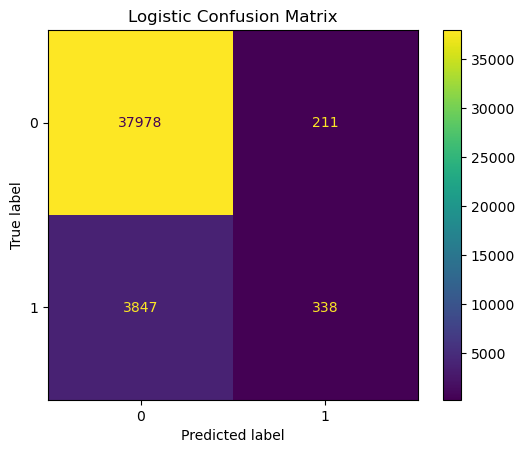

KNN training time: 0.2052600383758545 secs
KNN prediction and performance metrics time: 42.052205085754395 secs


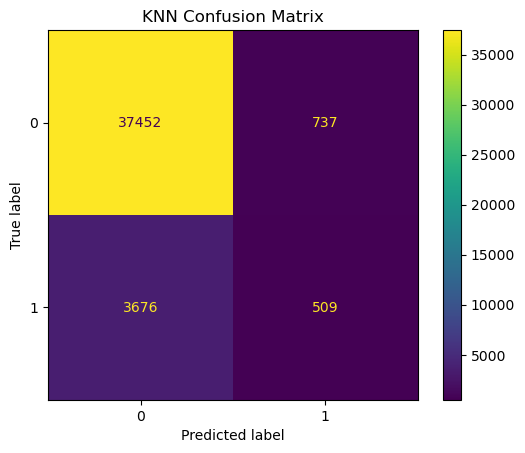

DecisionTree training time: 2.560082197189331 secs
DecisionTree prediction and performance metrics time: 0.5303831100463867 secs


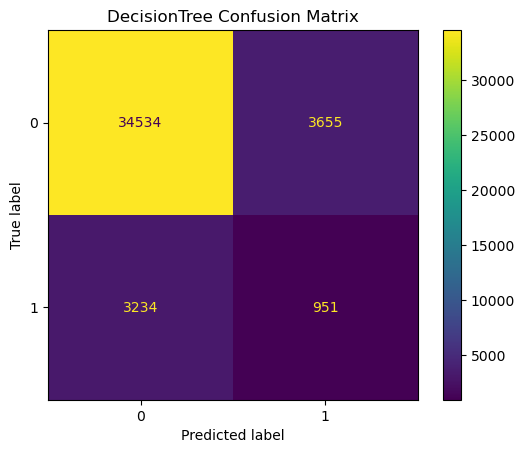

RandomForest training time: 6.4723780155181885 secs
RandomForest prediction and performance metrics time: 1.3138980865478516 secs


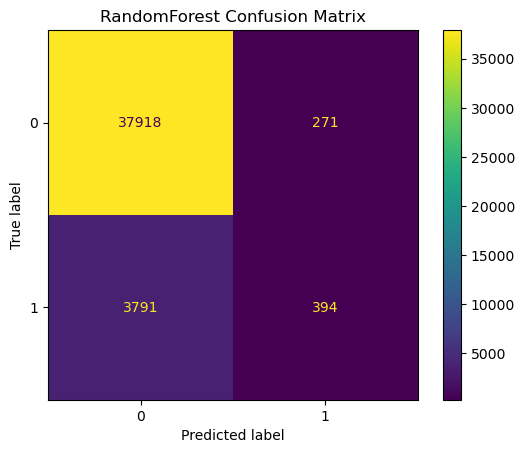

GradientBoosting training time: 29.33373498916626 secs
GradientBoosting prediction and performance metrics time: 0.7168190479278564 secs


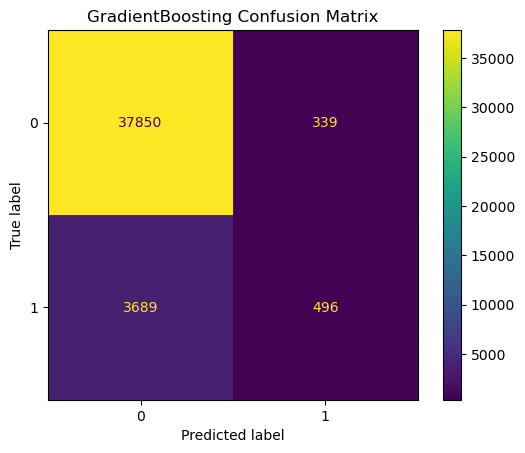

AdaBoost training time: 2.644375801086426 secs
AdaBoost prediction and performance metrics time: 0.4818599224090576 secs


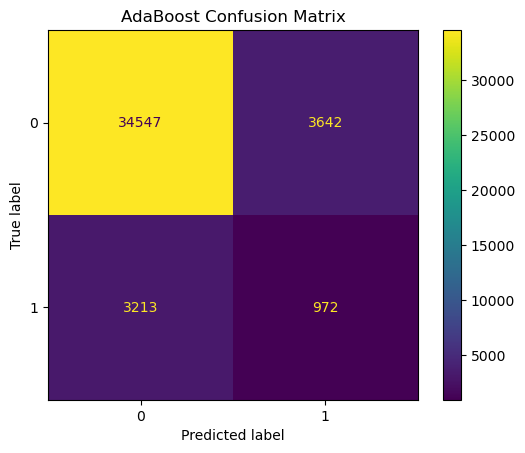

GaussianNB training time: 0.2624802589416504 secs
GaussianNB prediction and performance metrics time: 0.5095081329345703 secs


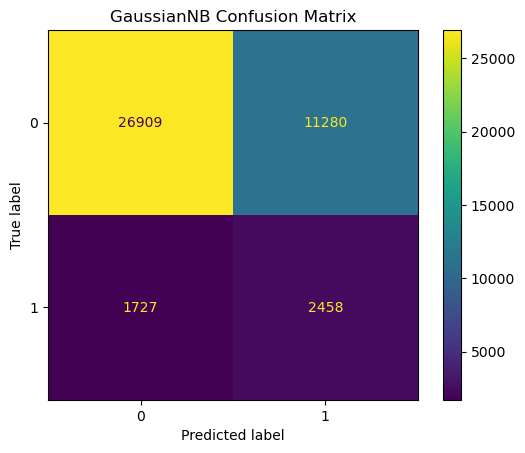

In [410]:
pipelines = {}
for model in models:
    pipelines[model["name"]] = model['pipeline']
    start_time = time.time()
    pipelines[model["name"]].fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f'{model["name"]} training time: {train_time} secs')
    predict_probas[model["name"]] = pipelines[model["name"]].predict_proba(X_test)[:, 1]
    start_time = time.time()
    model_performance_df, y_pred = model_performance_df_concat(
        model['name'], train_time, pipelines[model["name"]], model_performance_df)
    print(f'{model["name"]} prediction and performance metrics time: {time.time() - start_time} secs')
    
    # Plot the confusion matrix in a new figure
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.title(f'{model["name"]} Confusion Matrix')
    plt.savefig(f'images/confusion_matrix_{model["name"]}.png')
    plt.show()




In [411]:
model_performance_df

Model  Train Time  Train Accuracy %  Test Accuracy %  \
0          Logistic    2.607854         90.263315        90.423373   
1               KNN    0.205260         91.323535        89.585595   
2      DecisionTree    2.560082        100.000000        83.742389   
3      RandomForest    6.472378         99.994690        90.413933   
4  GradientBoosting   29.333735         90.695781        90.494171   
5          AdaBoost    2.644376        100.000000        83.822627   
6        GaussianNB    0.262480         69.306697        69.304290   

   Train Recall %  Test Recall %  Train Precision %  Test Precision %  \
0        7.139017       8.076464          55.478180         61.566485   
1       21.990561      12.162485          69.074873         40.850722   
2      100.000000      22.724014         100.000000         20.646982   
3       99.946233       9.414576         100.000000         59.248120   
4       12.963737      11.851852          64.372590         59.401198   
5      100.000000      23.225806         100.000000         21.066320   
6       59.949818      58.733572          18.128771         17.891978   

   Train F1 %  Test F1 %  Train ROC AUC %  Test ROC AUC %  Train Log Loss  \
0   12.650188  14.279679        53.255605       53.761974    3.509457e+00   
1   33.360522  18.744246        60.455851       55.116305    3.127315e+00   
2  100.000000  21.635764       100.000000       56.576598    2.220446e-16   
3   99.973109  16.247423        99.973117       54.352474    1.913901e-03   
4   21.581303  19.760956        56.088753       55.482081    3.353580e+00   
5  100.000000  22.093420       100.000000       56.844514    2.220446e-16   
6   27.839041  27.428444        65.140927       64.598135    1.106299e+01   

   Test Log Loss  
0       3.451766  
1       3.753732  
2       5.859837  
3       3.455169  
4       3.426248  
5       5.830916  
6      11.063855

# Hyperparameter tuning

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5] END ......................model__C=0.1;, score=0.125 total time=   0.7s
[CV 3/5] END ........................model__C=1;, score=0.125 total time=   0.8s
[CV 4/5] END ........................model__C=1;, score=0.123 total time=   1.2s
Logistic GridSearchCV training time: 7.933232307434082 secs
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=1, max_iter=5000, n_jobs=-1,
                                    random_state=25))])
Logistic best model prediction and performance metrics time: 0.3934149742126465 secs


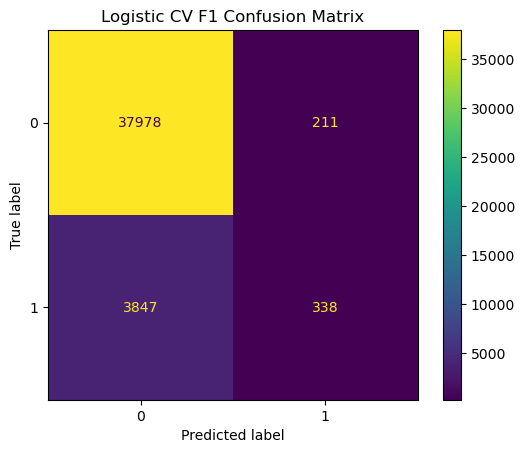

Fitting 5 folds for each of 1 candidates, totalling 5 fits
KNN GridSearchCV training time: 23.3540358543396 secs
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])
KNN best model prediction and performance metrics time: 35.39427590370178 secs


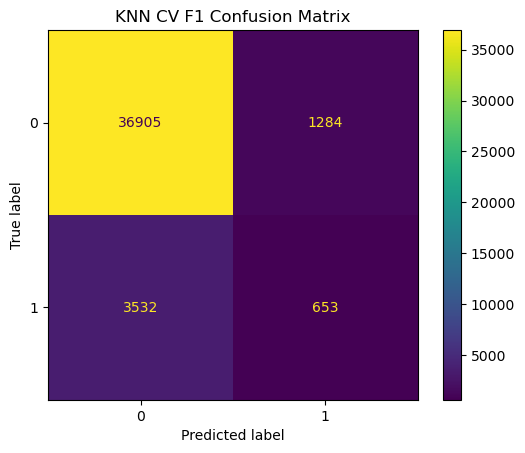

Fitting 5 folds for each of 4 candidates, totalling 20 fits
DecisionTree GridSearchCV training time: 10.953439950942993 secs
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=25, random_state=25))])
DecisionTree best model prediction and performance metrics time: 0.5084459781646729 secs


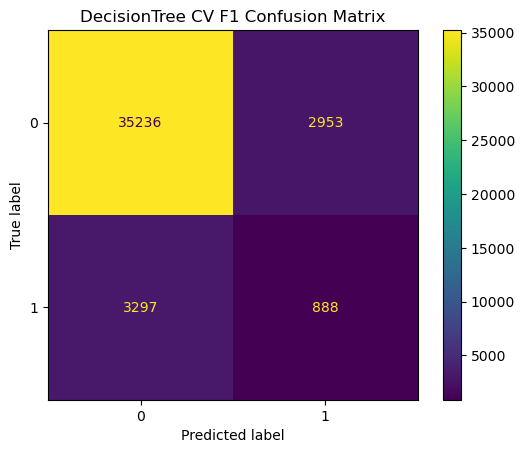

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 5/5] END ......................model__C=0.1;, score=0.135 total time=   2.1s
[CV 3/5] END ........................model__C=5;, score=0.125 total time=   0.7s
[CV 3/5] END model__n_neighbors=3, model__weights=distance;, score=0.204 total time=  22.9s
[CV 1/5] END ...............model__max_depth=30;, score=0.240 total time=   4.6s
[CV 2/5] END model__bootstrap=False, model__max_depth=20, model__min_samples_leaf=1, model__min_samples_split=1;, score=nan total time=   0.7s
[CV 2/5] END model__bootstrap=False, model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=1;, score=nan total time=   2.4s
[CV 4/5] END model__bootstrap=False, model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=1;, score=nan total time=   2.9s
[CV 1/5] END model__bootstrap=False, model__max_depth=20, model__min_samples_leaf=2, model__min_samples_split=2;, score=0.178 total time= 1.1min
[CV 5/5] END model__bootstrap

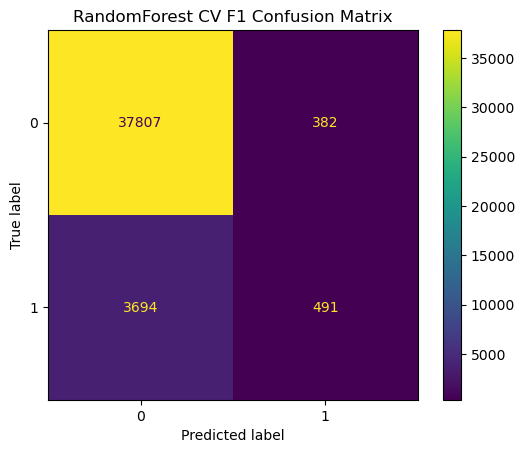

Fitting 5 folds for each of 9 candidates, totalling 45 fits
GradientBoosting GridSearchCV training time: 690.2997057437897 secs
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.2, max_depth=10,
                                            min_samples_leaf=2,
                                            min_samples_split=20,
                                            random_state=25))])
GradientBoosting best model prediction and performance metrics time: 0.9725019931793213 secs


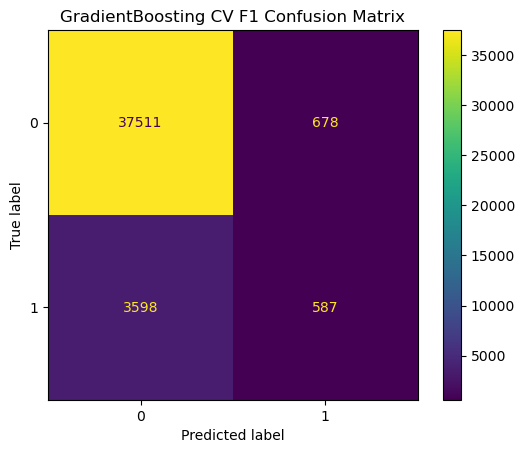

Fitting 5 folds for each of 6 candidates, totalling 30 fits
AdaBoost GridSearchCV training time: 438.69856309890747 secs
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=11,
                                                                     min_samples_leaf=2),
                                    random_state=25))])
AdaBoost best model prediction and performance metrics time: 1.9078519344329834 secs


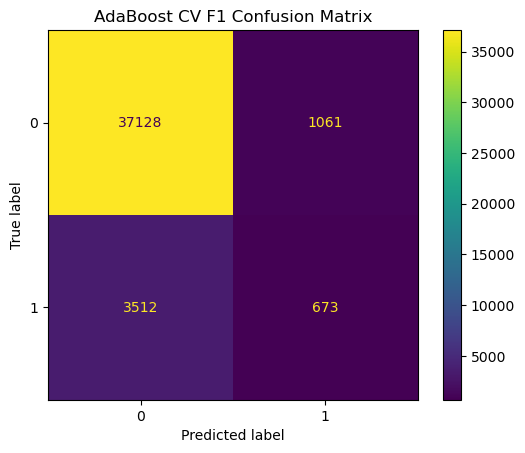

In [414]:
grids = {}
for model in models:
    if 'params' not in model:
        continue
    pipe = model['pipeline']
    grids[model["name"]] = GridSearchCV(estimator=pipe, param_grid=model['params'], scoring=make_scorer(f1_score), n_jobs=-1, cv=5, verbose=5)
    start_time = time.time()
    grids[model["name"]].fit(X_train, y_train)
    end_time = time.time()
    total_train_time = end_time - start_time
    print(f'{model["name"]} GridSearchCV training time: {total_train_time} secs')
    predict_probas[f'{model["name"]} CV F1'] = grids[model["name"]].predict_proba(X_test)[:, 1]
    print(grids[model["name"]].best_estimator_)
    # Calculate the average training time per fit iteration
    train_time = total_train_time / grids[model["name"]].cv_results_['mean_fit_time'].shape[0]
    start_time = time.time()
    model_performance_df, y_pred = model_performance_df_concat(
        f"{model['name']} CV F1", train_time, grids[model["name"]], model_performance_df)
    print(f'{model["name"]} best model prediction and performance metrics time: {time.time() - start_time} secs')

    # Plot the confusion matrix in a new figure
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_display.plot()
    plt.title(f'{model["name"]} CV F1 Confusion Matrix')
    plt.savefig(f'images/confusion_matrix_{model["name"]}_CV_F1.png')
    plt.show()


In [415]:
model_performance_df

Model  Train Time  Train Accuracy %  Test Accuracy %  \
0                 Logistic    2.607854         90.263315        90.423373   
1                      KNN    0.205260         91.323535        89.585595   
2             DecisionTree    2.560082        100.000000        83.742389   
3             RandomForest    6.472378         99.994690        90.413933   
4         GradientBoosting   29.333735         90.695781        90.494171   
5                 AdaBoost    2.644376        100.000000        83.822627   
6               GaussianNB    0.262480         69.306697        69.304290   
7           Logistic CV F1    1.586646         90.263315        90.423373   
8                KNN CV F1   23.354036        100.000000        88.634540   
9       DecisionTree CV F1    2.738360         98.312025        85.250389   
10      RandomForest CV F1   21.767174         99.997050        90.380894   
11  GradientBoosting CV F1   76.699967         93.973202        89.908906   
12          AdaBoost CV F1   73.116427         95.280631        89.208005   

    Train Recall %  Test Recall %  Train Precision %  Test Precision %  \
0         7.139017       8.076464          55.478180         61.566485   
1        21.990561      12.162485          69.074873         40.850722   
2       100.000000      22.724014         100.000000         20.646982   
3        99.946233       9.414576         100.000000         59.248120   
4        12.963737      11.851852          64.372590         59.401198   
5       100.000000      23.225806         100.000000         21.066320   
6        59.949818      58.733572          18.128771         17.891978   
7         7.139017       8.076464          55.478180         61.566485   
8       100.000000      15.603345         100.000000         33.711926   
9        83.660912      21.218638          99.108280         23.118979   
10       99.970130      11.732378         100.000000         56.242841   
11       40.241353      14.026284          96.948762         46.403162   
12       56.932911      16.081243          92.344961         38.811995   

    Train F1 %  Test F1 %  Train ROC AUC %  Test ROC AUC %  Train Log Loss  \
0    12.650188  14.279679        53.255605       53.761974    3.509457e+00   
1    33.360522  18.744246        60.455851       55.116305    3.127315e+00   
2   100.000000  21.635764       100.000000       56.576598    2.220446e-16   
3    99.973109  16.247423        99.973117       54.352474    1.913901e-03   
4    21.581303  19.760956        56.088753       55.482081    3.353580e+00   
5   100.000000  22.093420       100.000000       56.844514    2.220446e-16   
6    27.839041  27.428444        65.140927       64.598135    1.106299e+01   
7    12.650188  14.279679        53.255605       53.761974    3.509457e+00   
8   100.000000  21.332898       100.000000       56.120560    2.220446e-16   
9    90.731802  22.128084        91.789213       56.743022    6.084080e-01   
10   99.985063  19.414788        99.985065       55.366045    1.063279e-03   
11   56.875079  21.541284        70.051284       56.125452    2.172278e+00   
12   70.438671  22.740328        78.207870       56.651478    1.701033e+00   

    Test Log Loss  
0        3.451766  
1        3.753732  
2        5.859837  
3        3.455169  
4        3.426248  
5        5.830916  
6       11.063855  
7        3.451766  
8        4.096527  
9        5.316299  
10       3.467077  
11       3.637199  
12       3.889829

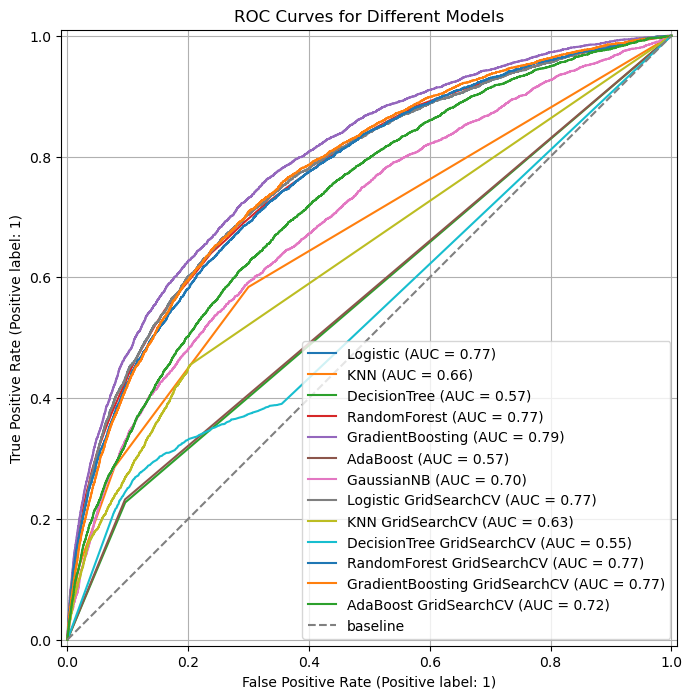

CPU times: user 1min 18s, sys: 1.35 s, total: 1min 20s
Wall time: 14.4 s


In [416]:
%%time
# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(12, 8))  # Set the size of the figure here

# Plot ROC curves for various models on the same axes for comparison
for pipe in pipelines:
    RocCurveDisplay.from_estimator(pipelines[pipe], X_test, y_test, ax=ax, name=pipe)

for grid in grids:
    RocCurveDisplay.from_estimator(grids[grid], X_test, y_test, ax=ax, name=f'{grid} GridSearchCV')

# Plot a diagonal line to represent a no-skill classifier (baseline)
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='baseline')

# Add a grid for better readability of the plot
ax.grid()

# Finalize the plot
ax.set_title('ROC Curves for Different Models')
ax.legend()  # This will now include all lines with labels

# Save and show the plot
plt.savefig('images/roc_curve.png')
plt.show()


In [417]:
roc_areas = {}
roc_areas['Model'] = list(predict_probas.keys())
roc_areas['ROC AUC Score'] = []
roc_areas

{'Model': ['Logistic',
  'KNN',
  'DecisionTree',
  'RandomForest',
  'GradientBoosting',
  'AdaBoost',
  'GaussianNB',
  'Logistic CV F1',
  'KNN CV F1',
  'DecisionTree CV F1',
  'RandomForest CV F1',
  'GradientBoosting CV F1',
  'AdaBoost CV F1'],
 'ROC AUC Score': []}

In [418]:
for model in roc_areas['Model']:
    roc_areas['ROC AUC Score'].append(roc_auc_score(y_test, predict_probas[model]))

In [419]:
roc_areas_df = pd.DataFrame(roc_areas)
roc_areas_df

Model  ROC AUC Score
0                 Logistic       0.770101
1                      KNN       0.664311
2             DecisionTree       0.565766
3             RandomForest       0.769018
4         GradientBoosting       0.791920
5                 AdaBoost       0.568445
6               GaussianNB       0.696612
7           Logistic CV F1       0.770101
8                KNN CV F1       0.634780
9       DecisionTree CV F1       0.548056
10      RandomForest CV F1       0.765705
11  GradientBoosting CV F1       0.770662
12          AdaBoost CV F1       0.724107

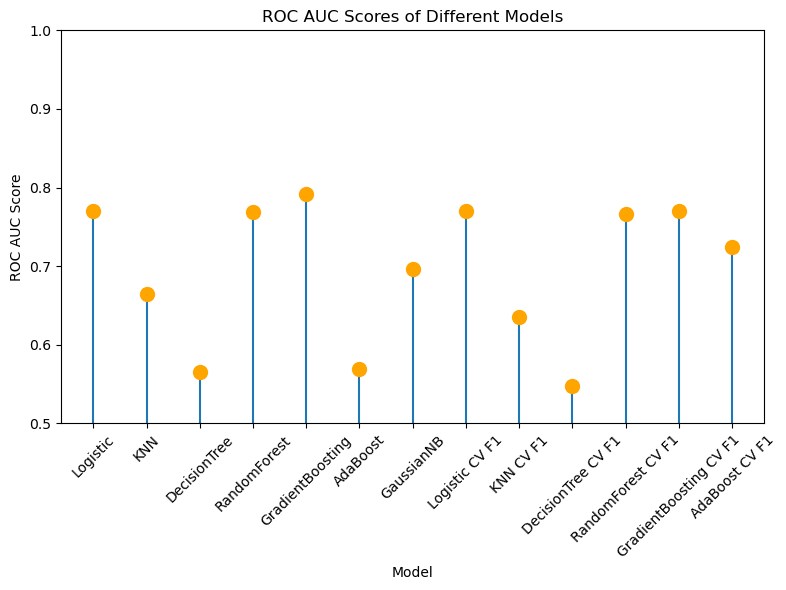

In [420]:
# Create lollipop chart
plt.figure(figsize=(8, 6))
plt.stem(roc_areas_df['Model'], roc_areas_df['ROC AUC Score'], basefmt=" ")
plt.scatter(roc_areas_df['Model'], roc_areas_df['ROC AUC Score'], color='orange', s=100, zorder=3)
plt.xticks(rotation=45)
plt.title('ROC AUC Scores of Different Models')
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.ylim(0.5, 1.0)  # Ensures that the y-axis starts from 0.5 to better visualize the differences
plt.tight_layout()
plt.savefig('images/ROC_AUC.png')
plt.show()


In [421]:
metrics = ['Train Time', 'Test Accuracy %', 'Test Recall %', 'Test Precision %', 'Test F1 %']

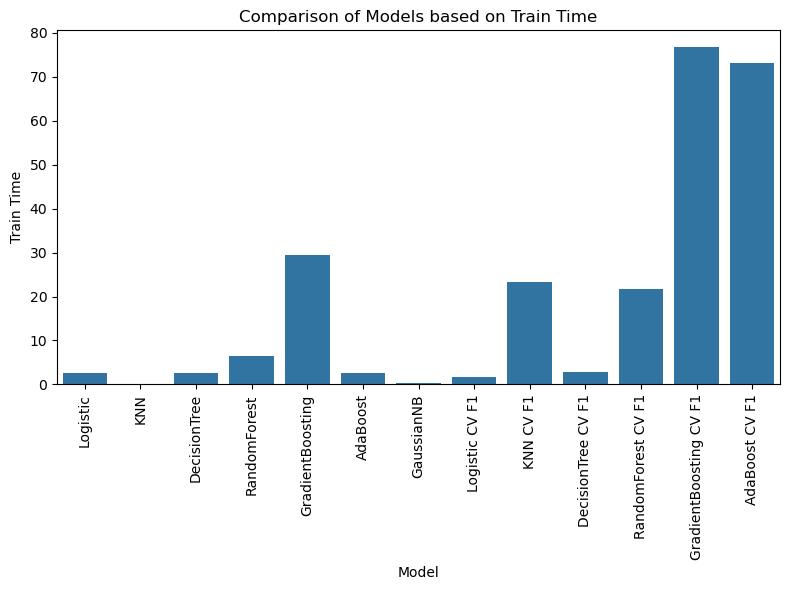

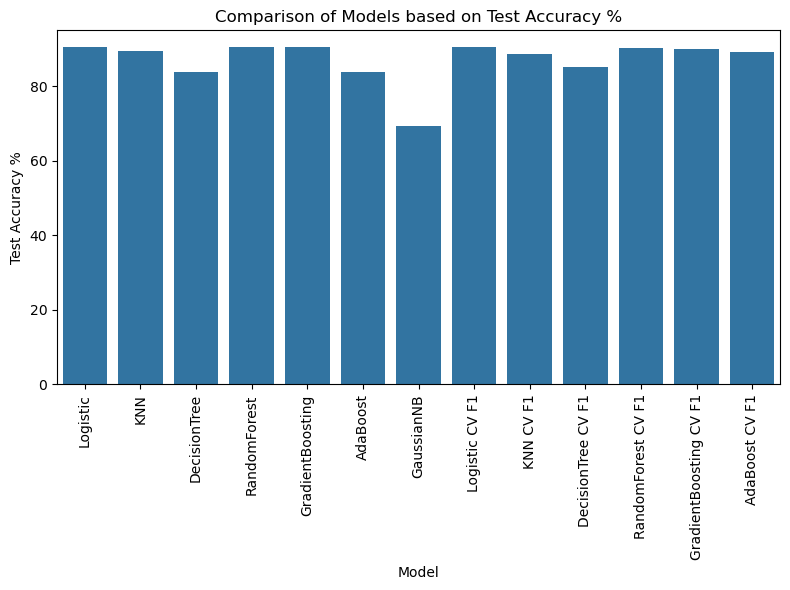

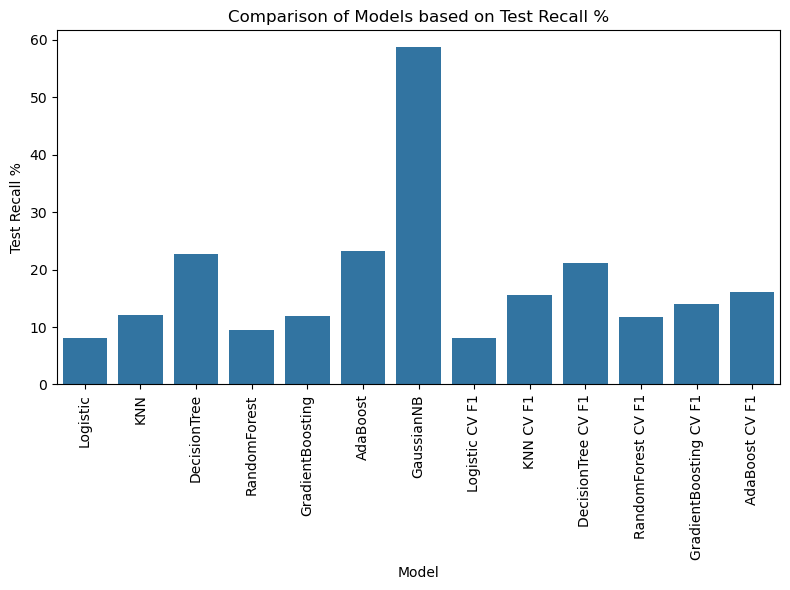

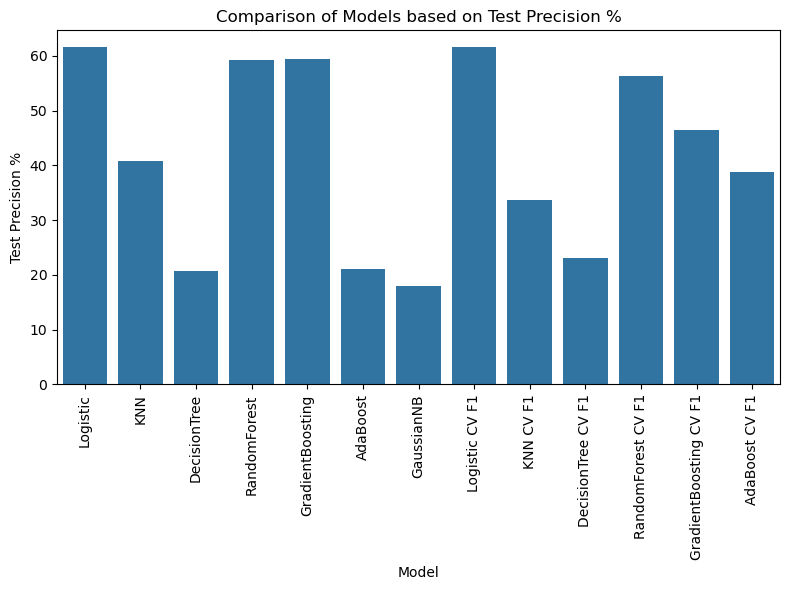

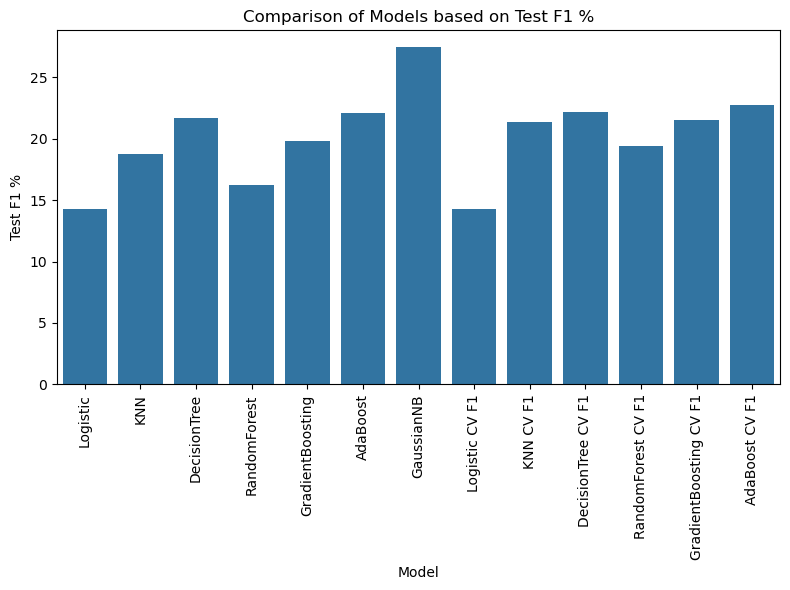

In [422]:
# Loop through each metric listed in the 'metrics' list
for metric in metrics:
    plt.figure(figsize=(8, 6))
    # Create a bar plot to compare different models based on the current metric
    sns.barplot(x='Model', y=metric, data=model_performance_df)
    plt.title(f'Comparison of Models based on {metric}')
    plt.xticks(rotation=90)  # Rotate the model names on x-axis for better visibility
    plt.ylabel(metric)
    plt.tight_layout()
    # Save the plot with a filename corresponding to the metric, replacing spaces with underscores
    plt.savefig(f'images/models_comp_by_{metric.lower().replace(" ", "_")}')
    plt.show()

In [423]:
X_train.head()

ordered_count  product_num_unique_orders  \
201449              8                       4596   
209553              1                      60621   
176759              1                       2367   
170562              1                      13692   
93271               1                         26   

        product_avg_add_to_cart_position  user_num_unique_orders  \
201449                          7.521540                      32   
209553                          9.197060                      88   
176759                         10.040135                      16   
170562                          9.049080                       9   
93271                           9.538462                       9   

        user_avg_products_per_order  user_num_unique_products  \
201449                    21.718750                       238   
209553                     7.159091                       236   
176759                    17.437500                       179   
170562                    17.333333                        59   
93271                     16.666667                        99   

        user_avg_days_between_orders  user_product_avg_add_to_cart_order  \
201449                     10.587706                                9.25   
209553                      5.414673                                6.00   
176759                     18.000000                               11.00   
170562                     25.007143                                5.00   
93271                      13.169118                                4.00   

        dept_alcohol  dept_babies  dept_bakery  dept_beverages  \
201449         False        False        False           False   
209553         False        False        False           False   
176759         False        False        False           False   
170562         False        False         True           False   
93271          False         True        False           False   

        dept_breakfast  dept_bulk  dept_canned goods  dept_dairy eggs  \
201449           False      False              False             True   
209553           False      False              False            False   
176759           False      False               True            False   
170562           False      False              False            False   
93271            False      False              False            False   

        dept_deli  dept_dry goods pasta  dept_frozen  dept_household  \
201449      False                 False        False           False   
209553      False                 False        False           False   
176759      False                 False        False           False   
170562      False                 False        False           False   
93271       False                 False        False           False   

        dept_international  dept_meat seafood  dept_missing  dept_other  \
201449               False              False         False       False   
209553               False              False         False       False   
176759               False              False         False       False   
170562               False              False         False       False   
93271                False              False         False       False   

        dept_pantry  dept_personal care  dept_pets  dept_produce  dept_snacks  
201449        False               False      False         False        False  
209553        False               False      False          True        False  
176759        False               False      False         False        False  
170562        False               False      False         False        False  
93271         False               False      False         False        False

### Feature Importance

In [426]:
best_gradient_boosting = grids['GradientBoosting'].best_estimator_.named_steps['model']

feature_importance = best_gradient_boosting.feature_importances_
features = X_train.columns

# Creating a DataFrame to view feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)


                               Feature  Importance
0                        ordered_count    0.268590
3               user_num_unique_orders    0.136885
6         user_avg_days_between_orders    0.110880
4          user_avg_products_per_order    0.098324
1            product_num_unique_orders    0.096149
2     product_avg_add_to_cart_position    0.094577
5             user_num_unique_products    0.077493
7   user_product_avg_add_to_cart_order    0.070627
15                     dept_dairy eggs    0.005503
28                         dept_snacks    0.003856
18                         dept_frozen    0.003561
27                        dept_produce    0.003558
10                         dept_bakery    0.003542
11                      dept_beverages    0.003361
16                           dept_deli    0.003204
24                         dept_pantry    0.002540
12                      dept_breakfast    0.002388
21                   dept_meat seafood    0.002308
14                   dept_canne

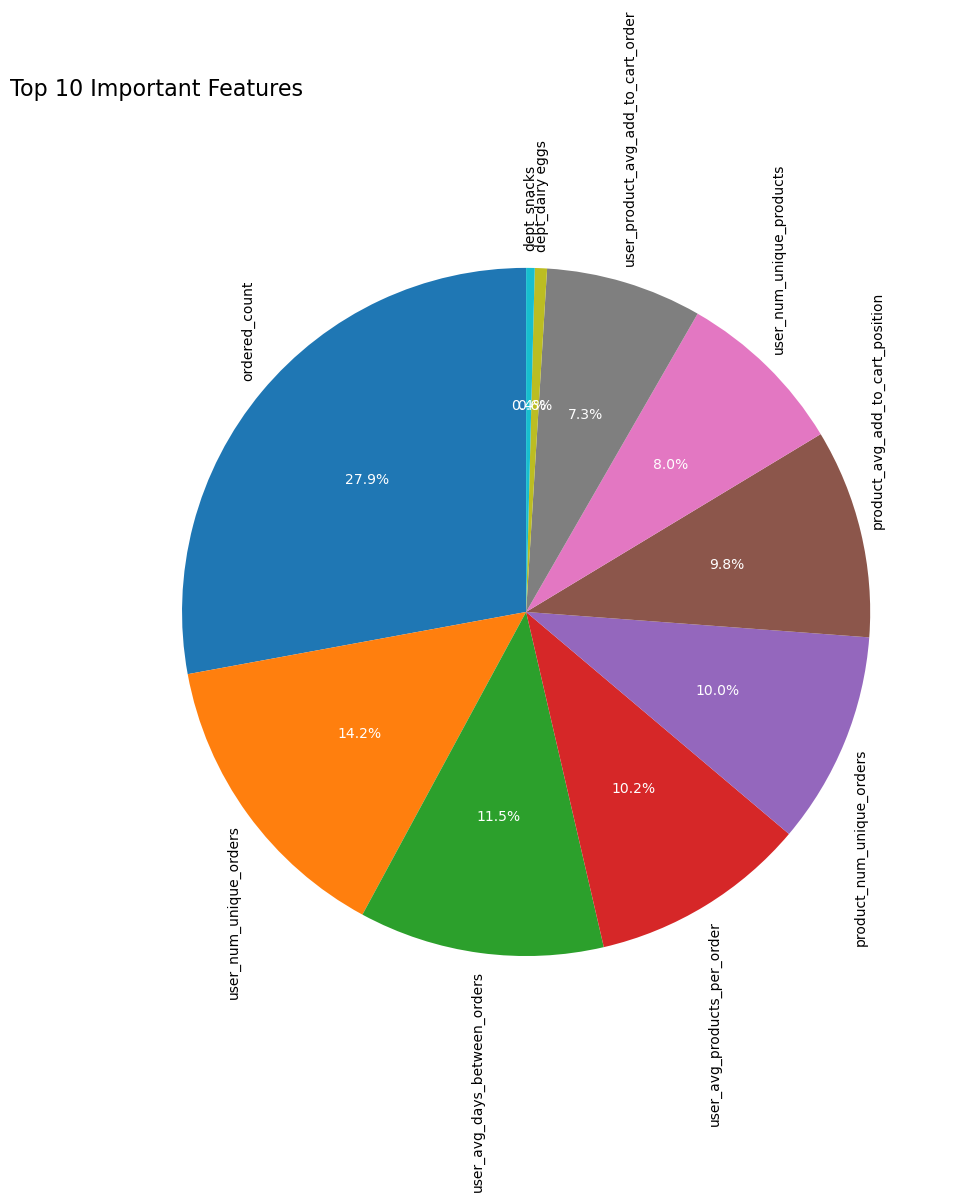

In [462]:
# Select top 10 features
top_10_features = importance_df.head(10)

# Create a pie plot for the top 10 important features
plt.figure(figsize=(16, 12))

# Customize the pie chart to improve label readability
wedges, texts, autotexts = plt.pie(
    top_10_features['Importance'], 
    labels=top_10_features['Feature'], 
    autopct='%1.1f%%', 
    startangle=90,
    labeldistance=1.05,  # Adjust label distance
    rotatelabels=True    # Rotate labels to match the angle of the slice
)

# Customize text properties
for text in texts:
    text.set_rotation(90)  # Rotate text labels
    text.set_horizontalalignment('center')  # Center the text

for autotext in autotexts:
    autotext.set_color('white')  # Change color of percentage text

# Move the title to the top-left corner
plt.text(-1.5, 1.5, 'Top 10 Important Features', fontsize=16, ha='left')
plt.tight_layout()
plt.savefig('images/feature_importances.png')
plt.show()


In [427]:
print(f'Time take for the notebook to run: {time.time() - notebook_start_time}')

Time take for the notebook to run: 18003.18314599991
